<a href="https://colab.research.google.com/github/EliasNoorzad/Pose6d_project/blob/main/models/training_RGBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading packages

In [ ]:
!pip install trimesh
!pip install --upgrade ipywidgets

## Mounting to Google Drive

In [ ]:
import os
from google.colab import drive

# Define the base path for your Google Drive.
base_path = '/content/drive'

# Define the specific folder path within your Google Drive.
folder_path = 'path/to/project'

# Combine the base path and folder path to create the full mount path.
full_project_path = os.path.join(base_path, folder_path)

# Mount your drive.
drive.mount(base_path, force_remount=True)

Mounted at /content/drive


## Creating custom dataset

In [ ]:
import os
import yaml
import cv2
import numpy as np
import json
import torch
import trimesh
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

class PoseEstimationDataset_RGBD(Dataset):
    """
    Custom PyTorch Dataset class for loading RGB-D images and pose annotations
    from the LineMOD dataset for 6D object pose estimation tasks.
    """
    def __init__(self, dataset_root,
                 models_root,
                 folders=list(range(1, 16)),
                 split='train',
                 val_ratio=0.8,
                 seed=42,
                 img_size=(224, 224)):
        """
        Initialize dataset by loading metadata and preparing the image/pose samples.

        Args:
            dataset_root (str): Path to the root of the RGB-D dataset.
            models_root (str): Path to the directory containing 3D object models and models_info.yml.
            folders (list): List of object folders to include.
            split (str): 'train' or 'val' split.
            train_ratio (float): Ratio of samples to include in the training set.
            seed (int): Random seed for train/test split reproducibility.
            img_size (tuple): Target image size for network input.
        """
        self.dataset_root = dataset_root
        self.models_root = models_root
        self.split = split
        self.val_ratio = val_ratio
        self.seed = seed
        self.img_size = img_size
        self.models = {}
        self.invalid_entries = 0

        # Load model metadata from YAML.
        self.models_info_path = os.path.join(models_root, 'models_info.yml')
        with open(self.models_info_path, 'r') as f:
            self.models_info = yaml.safe_load(f)

        # Chaching for effectice loading.
        self.gt_data = {}    # Ground truth poses.
        self.info_data = {}  # Camera intrinsics.
        self.all_samples = []  # All available (object_id, sample_id) pairs.

        # Load gt.yml and info.yml for each object folder.
        for obj_id in folders:
            obj_folder = os.path.join(dataset_root, f"{obj_id:02d}")
            gt_path = os.path.join(obj_folder, 'gt.yml')
            info_path = os.path.join(obj_folder, 'info.yml')

            if not os.path.exists(gt_path):
                continue

            with open(gt_path, 'r') as f:
                gt = yaml.safe_load(f)
            with open(info_path, 'r') as f:
                info = yaml.safe_load(f)

            self.gt_data[obj_id] = gt
            self.info_data[obj_id] = info

            for sample_id in gt.keys():
                self.all_samples.append((obj_id, int(sample_id)))

        # Building a mapping between original and internal object IDs.
        object_id_set = set()
        for obj_id, sample_id in self.all_samples:
            annotations = self.gt_data[obj_id][sample_id]
            for ann in annotations:
                object_id_set.add(ann['obj_id'])
        self.object_ids = sorted(object_id_set)
        self.id_to_idx = {obj_id: i for i, obj_id in enumerate(self.object_ids)}
        self.idx_to_id = {i: obj_id for obj_id, i in self.id_to_idx.items()}

        if not self.all_samples:
            raise ValueError(f"No samples found in {dataset_root}. Check dataset structure.")

        # Split dataset into training and test sets.
        #train, test = train_test_split(self.all_samples, train_size=self.train_ratio, random_state=self.seed)
        #self.samples = train if self.split == 'train' else test

        # Split filtering using per-object train/test.txt.
        selected_samples = []
        for obj_id in folders:
            obj_folder = os.path.join(dataset_root, f"{obj_id:02d}")
            split_file = 'train.txt' if self.split == 'train' else 'test.txt'
            split_path = os.path.join(obj_folder, split_file)

            if not os.path.exists(split_path):
                print(f"⚠️ Warning: Missing {split_file} in folder {obj_id:02d}, skipping.")
                continue

            # Load sample IDs from the split file.
            with open(split_path, 'r') as f:
                all_ids = [int(line.strip()) for line in f if line.strip().isdigit()]

            if self.split in ['val', 'test']:
                np.random.seed(self.seed)
                np.random.shuffle(all_ids)

                split_index = int(self.val_ratio * len(all_ids))

                if self.split == 'val':
                    selected_ids = all_ids[:split_index]
                else:  # for 'test'.
                    selected_ids = all_ids[split_index:]
            else:
                selected_ids = all_ids  # for 'train'.

            for sample_id in selected_ids:
                selected_samples.append((obj_id, sample_id))

        self.samples = [s for s in self.all_samples if s in selected_samples]

        # Image preprocessing pipeline.
        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.samples)

    def save_mapping(self, filepath=None):
        """Save object ID to index mapping as JSON."""
        if filepath is None:
            filepath = "object_id_mapping.json"
        with open(filepath, "w") as f:
            json.dump(self.id_to_idx, f)

    @staticmethod
    def load_mapping(filepath=None):
        """Load object ID to index mapping from JSON file."""
        if filepath is None:
            filepath = "object_id_mapping.json"
        with open(filepath, "r") as f:
            mapping = json.load(f)
        return {int(k): v for k, v in mapping.items()}

    def printIDMapping(self):
        """Print human-readable object ID mapping."""
        print("Object ID Mapping (Original → Mapped):")
        for orig_id in self.object_ids:
            print(f"  {orig_id:02d} → {self.id_to_idx[orig_id]}")

    def nrInvalidObjects(self):
        """Return number of filtered-out invalid object crops."""
        return self.invalid_entries

    def getMappedIDs(self, ids=None):
        """
        Maps original object IDs to their training indices.

        Args:
            ids (list or None): Original object IDs. If None, returns all mappings.
        Returns:
            mapped_ids (list): Mapped training indices.
            orig_ids (list): Corresponding original object IDs.
        """
        mapped_ids = []
        orig_ids = []
        if ids is None:
            for orig_id in self.object_ids:
                mapped_ids.append(self.id_to_idx[orig_id])
                orig_ids.append(orig_id)
        else:
            for id in ids:
                if id in self.id_to_idx:
                    mapped_ids.append(self.id_to_idx[id])
                    orig_ids.append(id)
                else:
                    print(f"⚠️ Warning: Object ID {id} not found in dataset and will be ignored.")
        return mapped_ids, orig_ids

    def get_model_info(self, object_id):
        """Returns metadata (ex. diameter) for the specified object ID."""
        if object_id not in self.models_info:
            raise ValueError(f"Object ID {object_id} not in models_info.yml")
        return self.models_info[object_id]

    def load_3D_model(self, object_id):
        """
        Loads and returns the 3D model (in meters) of the specified object.
        Caches the result to avoid redundant loading.
        """
        if object_id in self.models:
            return self.models[object_id]

        model_path = os.path.join(self.models_root, f"obj_{object_id:02d}.ply")
        mesh = trimesh.load(model_path)
        points = mesh.vertices.astype(np.float32) / 1000.0
        self.models[object_id] = points
        return points

    def cropImages(self, image, annotations, cam_K, depth_image=None, mask_image=None):
        """
        Crops object regions from the image (rgb + depth) based on bounding boxes and adjusts the intrinsics.

        Args:
            image (PIL.Image): Original RGB image.
            annotations (list): Object annotations from gt.yml.
            cam_K (torch.Tensor): Original 3x3 camera intrinsic matrix.
            depth_image (PIL.Image or None): depth image.

        Returns:
            crop_entries (list): List of cropped image entries with adjusted intrinsics.
            cam_K (torch.Tensor): Original intrinsic matrix.
        """
        crop_entries = []
        width, height = image.size

        for ann in annotations:
            x, y, w, h = ann['obj_bb']
            x1 = max(0, x)
            y1 = max(0, y)
            x2 = min(width, x + w)
            y2 = min(height, y + h)

            if x2 <= x1 or y2 <= y1:
                self.invalid_entries += 1
                continue

            cropped = image.crop((x1, y1, x2, y2))
            original_crop_width, original_crop_height = cropped.size

            # Adjust camera intrinsics for the cropped region.
            cropped_K = cam_K.clone()
            cropped_K[0, 2] -= x1
            cropped_K[1, 2] -= y1

            # Resize crop and update intrinsics accordingly.
            cropped = cropped.resize(self.img_size, Image.BILINEAR)
            scale_x = self.img_size[0] / original_crop_width
            scale_y = self.img_size[1] / original_crop_height
            cropped_K[0, 0] *= scale_x
            cropped_K[0, 2] *= scale_x
            cropped_K[1, 1] *= scale_y
            cropped_K[1, 2] *= scale_y

            cropped_rgb_tensor = self.transform(cropped)

            # Extract pose (rotation, translation).
            R_mat = np.array(ann['cam_R_m2c'], dtype=np.float32).reshape(3, 3)
            t_vec = np.array(ann['cam_t_m2c'], dtype=np.float32) / 1000.0

            # Handle optional depth cropping.
            #if depth_image is not None:
            #    cropped_depth = depth_image.crop((x1, y1, x2, y2))
            #    cropped_depth = cropped_depth.resize(self.img_size, Image.BILINEAR)
            #    cropped_depth_tensor = transforms.ToTensor()(cropped_depth)
            #else:
            #    cropped_depth_tensor = None

            # Handle optional depth cropping.
            if depth_image is not None:
                d = depth_image[y1:y2, x1:x2]  # crop (H, W).
                d = d.numpy() if isinstance(d, torch.Tensor) else d

                # Optional: blur to smooth sensor noise.
                d = cv2.GaussianBlur(d, (3, 3), 0.5)

                # Resize to model input size.
                d = np.array(Image.fromarray(d).resize(self.img_size, Image.BILINEAR))
                cropped_depth_tensor = torch.from_numpy(d).unsqueeze(0).float()  # (1, H, W)
            else:
                cropped_depth_tensor = None

            # Handle optional mask cropping using tensor slicing.
            if mask_image is not None:
                m = mask_image[y1:y2, x1:x2]
                m_np = m.numpy() if isinstance(m, torch.Tensor) else np.array(m)
                m_np_uint8 = (m_np * 255).astype(np.uint8)
                # Ensure the array has 2 dimensions.
                if m_np_uint8.ndim > 2:
                    if m_np_uint8.shape[-1] in [1, 3, 4]: # Common channel dimensions
                        m_np_uint8 = m_np_uint8[..., 0] # Take the first channel
                    else:
                        m_np_uint8 = np.squeeze(m_np_uint8)
                        if m_np_uint8.ndim > 2:
                              print(f"⚠️ Warning: Mask array still has >2 dimensions after squeezing. Reshaping to (H, W). Original shape: {m_np.shape}")
                              h, w = m_np_uint8.shape[:2]
                              m_np_uint8 = m_np_uint8.flatten()[:h*w].reshape(h, w)
                if m_np_uint8.ndim == 2:
                    mask_resized_img = Image.fromarray(m_np_uint8, mode='L').resize(self.img_size, Image.NEAREST)
                    mask_resized = np.array(mask_resized_img)  # shape: (H, W)
                    cropped_mask_tensor = torch.from_numpy(mask_resized).unsqueeze(0).float() / 255.0  # shape: (1, H, W)
                    cropped_mask_tensor = (cropped_mask_tensor > 0.5).float()
                else:
                    print(f"⚠️ Warning: Could not convert mask to 2 dimensions. Skipping mask for this sample. Final shape: {m_np_uint8.shape}")
                    cropped_mask_tensor = None
            else:
                cropped_mask_tensor = None

            # Normalize bounding box coordinates to [0, 1].
            norm_bbox = torch.tensor([
                x1 / width,
                y1 / height,
                (x2 - x1) / width,
                (y2 - y1) / height
            ], dtype=torch.float32)

            crop_entries.append({
                'cropped_rgb': cropped_rgb_tensor,
                'cropped_depth': cropped_depth_tensor,
                'cropped_mask': cropped_mask_tensor,
                'cropped_K': cropped_K,
                'object_id': ann['obj_id'],
                'bbox': ann['obj_bb'],
                'norm_bbox': norm_bbox,
                'rotation': R_mat,
                'translation': t_vec
            })

        return crop_entries, cam_K

    def __getitem__(self, idx):
        """
        Load an RGB-D sample and return a dict with:
        - Original RGB and depth image
        - Cropped objects with pose and camera intrinsics
        """
        object_id, sample_id = self.samples[idx]
        folder = os.path.join(self.dataset_root, f"{object_id:02d}")

        rgb_path = os.path.join(folder, 'rgb', f"{sample_id:04d}.png")
        if not os.path.exists(rgb_path):
            raise FileNotFoundError(f"RGB image not found: {rgb_path}")
        rgb = Image.open(rgb_path).convert("RGB")

        mask_path = os.path.join(folder, 'mask', f"{sample_id:04d}.png")
        if os.path.exists(mask_path):
            mask = Image.open(mask_path)
            mask = np.array(mask).astype(np.uint8)
            mask = (mask > 0).astype(np.float32)  # Ensure values are only 0 or 1.
            mask_tensor = torch.from_numpy(mask)  # shape (H, W)

        depth_path = os.path.join(folder, 'depth', f"{sample_id:04d}.png")
        if not os.path.exists(depth_path):
            raise FileNotFoundError(f"Depth image not found: {depth_path}")
        depth = Image.open(depth_path)
        depth_np = np.array(depth).astype(np.float32)
        depth_np = np.clip(depth_np, 0, 2000) / 2000.0 # Normalizing depth image between [0, 2].
        #depth_img = Image.fromarray((depth_np * 255).astype(np.uint8))
        depth_tensor = torch.from_numpy(depth_np).float()  # shape (H, W)

        annotations = self.gt_data[object_id][sample_id]
        cam_K = torch.tensor(np.array(self.info_data[object_id][sample_id]['cam_K']).reshape(3, 3), dtype=torch.float32)

        crop_entries, org_K = self.cropImages(rgb, annotations, cam_K, depth_image=depth_tensor, mask_image=mask_tensor)

        # Map object IDs to internal indices.
        for entry in crop_entries:
            true_obj_id = entry['object_id']
            if true_obj_id not in self.id_to_idx:
                raise ValueError(f"Object ID {true_obj_id} not found in id_to_idx mapping.")
            entry['object_id'] = self.id_to_idx[true_obj_id]

        return {
            'sample_id': sample_id,
            'original_rgb': rgb,
            'original_K': org_K,
            'original_depth': depth_tensor,
            'objects': crop_entries
        }

## PoseNet6D using RGB-D data

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

class PoseNet6D_RGBD(nn.Module):
    def __init__(self, num_objects, embedding_dim=32, fused_channels=512, img_size=(224, 224)):
        super().__init__()
        self.input_size = img_size

        # === RGB Backbone ===
        rgb_backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.rgb_encoder = nn.Sequential(*list(rgb_backbone.children())[:-2])  # (B, 512, 7, 7)

        # === Depth Backbone ===
        self.depth_encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7))  # Matches ResNet output.
        )

        # === Object ID embedding ===
        self.obj_embedding = nn.Embedding(num_objects, embedding_dim)

        # === Fusion block ===
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(512 + 256, fused_channels, kernel_size=1),
            nn.BatchNorm2d(fused_channels),
            nn.ReLU(),
        )

        # === Regression head ===
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        self.regressor = nn.Sequential(
            nn.Linear(fused_channels + embedding_dim + 4, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )

        self.fc_rot = nn.Linear(128, 4)  # Quaternion.
        self.fc_trans_z = nn.Linear(128, 1)  # Predict Z depth.

    def forward(self, rgb, depth, norm_bbox, K_crop, object_id):
        B = rgb.size(0)

        rgb_feat = self.rgb_encoder(rgb)       # (B, 512, H/32, W/32)
        depth_feat = self.depth_encoder(depth) # (B, 256, H/32, W/32)

        fused = torch.cat([rgb_feat, depth_feat], dim=1)  # (B, 768, H/32, W/32)
        fused = self.fusion_conv(fused)                   # (B, fused_channels, H/32, W/32)
        feat_vec = self.global_pool(fused).view(B, -1)    # (B, fused_channels)

        object_id = object_id.to(rgb.device)
        obj_embed = self.obj_embedding(object_id)         # (B, embedding_dim)

        x = torch.cat([feat_vec, obj_embed, norm_bbox], dim=1)  # (B, combined)
        x = self.regressor(x)

        quat = F.normalize(self.fc_rot(x), dim=1)  # (B, 4)
        depth_z = torch.clamp(self.fc_trans_z(x).squeeze(1), 0.1, 1.5)  # (B,)

        # === Back-project to 3D coordinates ===
        fx = K_crop[:, 0, 0]
        fy = K_crop[:, 1, 1]
        cx_crop = K_crop[:, 0, 2]
        cy_crop = K_crop[:, 1, 2]

        img_w, img_h = self.input_size
        u = (norm_bbox[:, 0] + 0.5 * norm_bbox[:, 2]) * img_w
        v = (norm_bbox[:, 1] + 0.5 * norm_bbox[:, 3]) * img_h

        x_cam = (u - cx_crop) * depth_z / fx
        y_cam = (v - cy_crop) * depth_z / fy
        z_cam = depth_z

        translation = torch.stack([x_cam, y_cam, z_cam], dim=1)  # (B, 3)

        return translation, quat

## Helper functions

In [ ]:
import torch.nn.functional as F
from scipy.spatial.transform import Rotation as R
from scipy.spatial import cKDTree

def computeADD(R_pred, t_pred, R_gt, t_gt, model_points):
    """
    Computes the ADD (Average Distance of Model Points) metric.

    Args:
        R_pred (np.ndarray or Tensor): Predicted rotation matrix (3x3).
        t_pred (np.ndarray or Tensor): Predicted translation vector (3,).
        R_gt (np.ndarray or Tensor): Ground truth rotation matrix (3x3).
        t_gt (np.ndarray or Tensor): Ground truth translation vector (3,).
        model_points (np.ndarray or Tensor): 3D object model points (N, 3).

    Returns:
        float: Mean Euclidean distance between transformed predicted and ground truth points.
    """
    def to_np(x):
        return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x

    # Convert all inputs to NumPy arrays.
    R_pred, t_pred = to_np(R_pred), to_np(t_pred)
    R_gt, t_gt = to_np(R_gt), to_np(t_gt)
    model_points = to_np(model_points)

    # Apply transformations to model points.
    pred_pts = model_points @ R_pred.T + t_pred
    gt_pts = model_points @ R_gt.T + t_gt

    # Compute mean L2 distance.
    distances = np.linalg.norm(pred_pts - gt_pts, axis=1)
    return distances.mean()

def matrix_to_quaternion_batch(rotation_matrix):
    """
    Converts a batch of rotation matrices to quaternions.

    Args:
        rotation_matrix (Tensor): (B, 3, 3) or (3, 3) rotation matrix.

    Returns:
        Tensor: (B, 4) batch of normalized quaternions (w, x, y, z).
    """
    if rotation_matrix.dim() == 2:
        rotation_matrix = rotation_matrix.unsqueeze(0)  # Ensure batch dimension.

    batch_size = rotation_matrix.size(0)
    quaternions = torch.zeros(batch_size, 4, device=rotation_matrix.device)

    # Compute trace for each matrix.
    trace = torch.diagonal(rotation_matrix, dim1=1, dim2=2).sum(dim=1)
    trace = torch.clamp(trace, min=-0.999)  # Stability clamp

    # Compute scalar (w) part.
    s = torch.sqrt(1.0 + trace) / 2.0
    quaternions[:, 0] = s

    # Prevent division by zero.
    denom = 4.0 * s
    denom = torch.clamp(denom, min=1e-6)

    # Compute vector part (x, y, z).
    quaternions[:, 1] = (rotation_matrix[:, 2, 1] - rotation_matrix[:, 1, 2]) / denom
    quaternions[:, 2] = (rotation_matrix[:, 0, 2] - rotation_matrix[:, 2, 0]) / denom
    quaternions[:, 3] = (rotation_matrix[:, 1, 0] - rotation_matrix[:, 0, 1]) / denom

    # Normalize result quaternion.
    return F.normalize(quaternions, dim=1)

def quaternion_to_matrix_batch(quat):
    """
    Converts a batch of quaternions to rotation matrices.

    Args:
        quat (Tensor): (B, 4) or (4,) quaternions in (w, x, y, z) format.

    Returns:
        Tensor: (B, 3, 3) batch of rotation matrices.
    """
    if quat.dim() == 1:
        quat = quat.unsqueeze(0)  # Ensure batch dimension.

    w, x, y, z = quat[:, 0], quat[:, 1], quat[:, 2], quat[:, 3]
    B = quat.size(0)
    R = torch.zeros((B, 3, 3), device=quat.device)

    # Populate rotation matrix elements from quaternion.
    R[:, 0, 0] = 1 - 2 * (y**2 + z**2)
    R[:, 0, 1] = 2 * (x * y - z * w)
    R[:, 0, 2] = 2 * (x * z + y * w)
    R[:, 1, 0] = 2 * (x * y + z * w)
    R[:, 1, 1] = 1 - 2 * (x**2 + z**2)
    R[:, 1, 2] = 2 * (y * z - x * w)
    R[:, 2, 0] = 2 * (x * z - y * w)
    R[:, 2, 1] = 2 * (y * z + x * w)
    R[:, 2, 2] = 1 - 2 * (x**2 + y**2)

    return R.squeeze(0) if quat.size(0) == 1 else R

def quaternion_loss(quat_pred, quat_gt):
    """
    Computes quaternion-based rotation loss.

    Args:
        quat_pred (Tensor): (B, 4) predicted quaternions.
        quat_gt (Tensor): (B, 4) ground truth quaternions.

    Returns:
        Tensor: Scalar loss measuring angular difference.
    """
    quat_pred = F.normalize(quat_pred, dim=1)
    quat_gt = F.normalize(quat_gt, dim=1)

    # Dot product gives cosine of half-angle between quaternions.
    dot = torch.sum(quat_pred * quat_gt, dim=1)
    dot = torch.abs(dot)
    dot = torch.clamp(dot, -1.0 + 1e-4, 1.0 - 1e-4)

    # Loss is 1 - cos²(theta) to minimize angular error.
    return (1 - dot**2).mean()

def quaternion_angular_error(q1, q2):
    """
    Computes angular error between two batches of quaternions.

    Args:
        q1 (Tensor): (B, 4) predicted quaternions.
        q2 (Tensor): (B, 4) ground truth quaternions.

    Returns:
        Tensor: (B,) angular error in degrees.
    """
    dot = torch.sum(q1 * q2, dim=1).clamp(-1.0, 1.0)
    dot = torch.abs(dot)  # Resolves the ±q ambiguity.
    angle = 2 * torch.acos(dot) * (180.0 / torch.pi)
    return angle

def computeMSE(rot_pred, t_pred, rot_gt, t_gt, quat=False,
               weight_xyz=(1.0, 1.0, 0.1), beta=1.0, print_mse=False):
    """
    Computes combined MSE loss for translation and rotation.

    Args:
        rot_pred (Tensor): (B, 4) or (B, 3, 3) predicted rotation.
        t_pred (Tensor): (B, 3) predicted translation.
        rot_gt (Tensor): ground truth rotation.
        t_gt (Tensor): ground truth translation.
        quat (bool): If True, use quaternion loss; else use matrix loss.
        weight_xyz (tuple): Weights for (x, y, z) translation axes.
        beta (float): Weight for rotation loss term.
        print_mse (bool): If True, print detailed loss values.

    Returns:
        tuple: (total_loss, (x_loss, y_loss, z_loss, angle_deg))
    """
    # Clamp Z translation to avoid numerical instability in log.
    t_pred = torch.clamp(t_pred, min=1e-3)
    t_gt = torch.clamp(t_gt, min=1e-3)

    # Weighted MSE translation loss (with log scaling for Z).
    x_loss = F.mse_loss(t_pred[:, 0], t_gt[:, 0]) * weight_xyz[0]
    y_loss = F.mse_loss(t_pred[:, 1], t_gt[:, 1]) * weight_xyz[1]
    z_loss = F.mse_loss(torch.log(t_pred[:, 2]), torch.log(t_gt[:, 2])) * weight_xyz[2]
    translation_loss = x_loss + y_loss + z_loss

    # Rotation loss: quaternion or matrix.
    if quat:
        rotation_loss = quaternion_loss(rot_pred, rot_gt)
    else:
        rot_diff = torch.bmm(rot_pred.transpose(1, 2), rot_gt)
        identity = torch.eye(3, device=rot_pred.device).unsqueeze(0).expand(rot_pred.size(0), -1, -1)
        rotation_loss = F.mse_loss(rot_diff, identity)

    # Combine the losses.
    total_loss = translation_loss + beta * rotation_loss

    # Optional logging.
    angle_deg = None
    if print_mse:
        print(f"\nX loss:           {x_loss:.6f}")
        print(f"Y loss:           {y_loss:.6f}")
        print(f"Z loss:           {z_loss:.6f}")
        print(f"Rotation loss:    {rotation_loss:.6f}")
        print(f"Total loss:       {total_loss:.6f}")
        if quat:
            angle_deg = quaternion_angular_error(rot_pred, rot_gt).mean().item()
            print(f"Angular error (deg): {angle_deg:.2f}")

    return total_loss, (x_loss, y_loss, z_loss, angle_deg)

def flatten_collate_fn(batch):
    """
    Custom collate function for DataLoader to flatten all object crops
    from each scene into a single batch.

    Args:
        batch (list): List of dicts from __getitem__ containing 'objects' lists.

    Returns:
        dict: Batched tensors for rgb, depth, rotation, translation, etc.
    """
    flat_data = []

    # Iterate over samples and flatten all object entries.
    for sample in batch:
        for obj in sample['objects']:
            flat_data.append({
                'rgb': obj['cropped_rgb'],
                'depth': obj['cropped_depth'],
                'rotation': torch.tensor(obj['rotation'], dtype=torch.float32),
                'translation': torch.tensor(obj['translation'], dtype=torch.float32),
                'object_id': obj['object_id'],
                'cropped_mask': obj['cropped_mask'] if obj['cropped_mask'] is not None else torch.ones_like(obj['cropped_depth']),
                'bbox': obj['norm_bbox'].clone().detach(),
                'cropped_K': obj['cropped_K'].clone().detach()
            })

    # Stack each field into batch tensors.
    rgb = torch.stack([item['rgb'] for item in flat_data])
    depth = torch.stack([item['depth'] for item in flat_data])
    rotation = torch.stack([item['rotation'] for item in flat_data])
    translation = torch.stack([item['translation'] for item in flat_data])
    object_ids = torch.tensor([item['object_id'] for item in flat_data], dtype=torch.int64)
    bbox = torch.stack([item['bbox'] for item in flat_data])
    mask = torch.stack([item['cropped_mask'] for item in flat_data])
    cropped_K = torch.stack([item['cropped_K'] for item in flat_data])

    return {
        'rgb': rgb,
        'depth': depth,
        'rotation': rotation,
        'translation': translation,
        'object_id': object_ids,
        'norm_bbox': bbox,
        'cropped_K': cropped_K,
        'mask': mask
    }

## Dataloaders

In [ ]:
from torch.utils.data import DataLoader
import os
import numpy as np

# Paths.
dataset_root = os.path.join(full_project_path, 'path/to/data')
models_root = os.path.join(full_project_path, 'path/to/models')

# Choose which object folders to include.
#folders = [5]
#folders = [1,4,5]  # Or list(range(1, 16)) for all.
folders = list(range(1,16))
print(f"Loading data folder(s): {folders}")

# Load training dataset.
train_dataset = PoseEstimationDataset_RGBD(
    dataset_root,
    models_root,
    folders=folders,
    split='train'
)

# Load validation dataset.
val_dataset = PoseEstimationDataset_RGBD(
    dataset_root,
    models_root,
    folders=folders,
    split='val',
)

# Load test dataset.
test_dataset = PoseEstimationDataset_RGBD(
    dataset_root,
    models_root,
    folders=folders,
    split='test',
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# List objects present in training set.
_, orig_ids = train_dataset.getMappedIDs()
print(f"Training on {len(orig_ids)} object types: {[f'{oid:02d}' for oid in sorted(orig_ids)]}")

# Dataloaders.
num_workers = 0
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=flatten_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=flatten_collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=flatten_collate_fn
)

# Save object ID mapping.
train_dataset.save_mapping()

Loading data folder(s): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
⚠️ Warning: Missing train.txt in folder 03, skipping.
⚠️ Warning: Missing train.txt in folder 07, skipping.
⚠️ Warning: Missing test.txt in folder 03, skipping.
⚠️ Warning: Missing test.txt in folder 07, skipping.
⚠️ Warning: Missing test.txt in folder 03, skipping.
⚠️ Warning: Missing test.txt in folder 07, skipping.
Training dataset size: 2373
Validation dataset size: 10720
Testing dataset size: 2687
Training on 13 object types: ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '14', '15']


## Inspecting dataset

In [ ]:
from collections import defaultdict

def inspect_val_test_image_ids(val_dataset, test_dataset):
    """
    Checks for overlapping image sample IDs between validation and test datasets.

    Args:
        val_dataset (PoseEstimationDataset): Validation set.
        test_dataset (PoseEstimationDataset): Test set.
    """
    def collect_ids(dataset):
        id_map = defaultdict(set)
        for obj_id, sample_id in dataset.samples:
            id_map[obj_id].add(sample_id)
        return id_map

    val_ids = collect_ids(val_dataset)
    test_ids = collect_ids(test_dataset)

    shared_images = {}
    unique_val = {}
    unique_test = {}

    print("\n🔍 Checking image ID overlap per object:")

    all_obj_ids = sorted(set(val_ids.keys()) | set(test_ids.keys()))
    for obj_id in all_obj_ids:
        val_set = val_ids.get(obj_id, set())
        test_set = test_ids.get(obj_id, set())
        shared = val_set & test_set
        only_val = val_set - test_set
        only_test = test_set - val_set

        shared_images[obj_id] = shared
        unique_val[obj_id] = only_val
        unique_test[obj_id] = only_test

        print(f"Object {obj_id:02d}:")
        print(f"  📂 1st dataset only:  {len(only_val)} images")
        print(f"  📂 2nd dataset only: {len(only_test)} images")
        print(f"  ⚠️ Shared:    {len(shared)} images")
        if len(shared) > 0:
            print(f"    → {sorted(shared)[:5]}{' ...' if len(shared) > 5 else ''}")

    total_shared = sum(len(v) for v in shared_images.values())
    print(f"\n✅ Total shared image IDs across datasets: {total_shared}")
    if total_shared == 0:
        print("🎉 No overlap between validation and test sets.")
    else:
        print("⚠️ Overlap detected. Consider revising your data split.")

print("\n=== Checking val_dataset vs. test_dataset. ===")
inspect_val_test_image_ids(val_dataset, test_dataset)
print("\n=== Checking train_dataset vs. val_dataset. ===")
inspect_val_test_image_ids(train_dataset, val_dataset)
print("\n=== Checking train_dataset vs. test_dataset. ===")
inspect_val_test_image_ids(train_dataset, test_dataset)


=== Checking val_dataset vs. test_dataset. ===

🔍 Checking image ID overlap per object:
Object 01:
  📂 1st dataset only:  840 images
  📂 2nd dataset only: 210 images
  ⚠️ Shared:    0 images
Object 04:
  📂 1st dataset only:  816 images
  📂 2nd dataset only: 204 images
  ⚠️ Shared:    0 images
Object 05:
  📂 1st dataset only:  812 images
  📂 2nd dataset only: 204 images
  ⚠️ Shared:    0 images

✅ Total shared image IDs across datasets: 0
🎉 No overlap between validation and test sets.

=== Checking train_dataset vs. val_dataset. ===

🔍 Checking image ID overlap per object:
Object 01:
  📂 1st dataset only:  186 images
  📂 2nd dataset only: 840 images
  ⚠️ Shared:    0 images
Object 04:
  📂 1st dataset only:  181 images
  📂 2nd dataset only: 816 images
  ⚠️ Shared:    0 images
Object 05:
  📂 1st dataset only:  180 images
  📂 2nd dataset only: 812 images
  ⚠️ Shared:    0 images

✅ Total shared image IDs across datasets: 0
🎉 No overlap between validation and test sets.

=== Checking train

## Functions for training, evaluation and testing

In [ ]:
from tqdm.notebook import tqdm

def train_model(epoch, model, train_loader, criterion, optimizer, device, use_mask_on_depth=False, use_mask_on_rgb=False):
    """
    Trains the PoseNet6D RGB-D model for one epoch.
    """
    model.train()
    running_loss = 0.0
    total = 0

    for batch_idx, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}', leave=False, unit="batch")):

        rgb = data['rgb'].to(device)
        depth = data['depth'].to(device)
        mask = data['mask']
        t_gt = data['translation'].to(device)
        R_gt = data['rotation'].to(device)
        norm_bbox = data['norm_bbox'].to(device)
        cropped_K = data['cropped_K'].to(device)
        object_ids = data['object_id'].to(device)

        if use_mask_on_depth:
            depth = depth * mask.to(device)

        if use_mask_on_rgb:
            rgb = rgb * mask.to(device).repeat(1, 3, 1, 1)

        t_pred, quat_pred = model(rgb, depth, norm_bbox, cropped_K, object_ids)
        quat_gt = matrix_to_quaternion_batch(R_gt)

        #if epoch < 5:
        #    beta = 1
        #    weight_xyz = (0, 0, 0.1)
        #elif epoch < 10:
        #    beta = 5
        #    weight_xyz = (0.5, 0.5, 0.4)
        #else:
        #    beta = 10
        #    weight_xyz = (0.1, 0.1, 1)

        weight_xyz = (1.0, 1.0, 3.0)
        beta = 1.0

        loss, _ = computeMSE(quat_pred, t_pred, quat_gt, t_gt,
                     quat=True, weight_xyz=weight_xyz, beta=beta)

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"⚠️ Skipping batch {batch_idx} due to invalid loss (NaN or Inf)")
            continue

        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += t_gt.size(0)

    train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch} | Loss: {train_loss:.6f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')
    return model

def evaluate_model(model, val_loader, dataset, device, track_per_object=False):
    """
    Evaluates the RGB-D model using ADD and MSE loss on the validation set.
    """
    model.eval()
    running_loss = 0.0
    add_total = 0.0
    num_samples = 0
    first_round = True

    idx_to_id = {v: k for k, v in dataset.load_mapping("object_id_mapping.json").items()}
    add_per_object = {orig_id: [] for orig_id in idx_to_id.values()} if track_per_object else None
    model_points_cache = {}

    with torch.no_grad():
        for data in tqdm(val_loader, desc="Evaluating", leave=False):
            rgb = data['rgb'].to(device)
            depth = data['depth'].to(device)
            t_gt = data['translation'].to(device)
            R_gt = data['rotation'].to(device)
            object_ids = data['object_id']
            norm_bbox = data['norm_bbox'].to(device)
            cropped_K = data['cropped_K'].to(device)

            t_pred, quat_pred = model(rgb, depth, norm_bbox, cropped_K, object_ids)
            quat_gt = matrix_to_quaternion_batch(R_gt)
            R_pred = quaternion_to_matrix_batch(quat_pred)

            loss, _ = computeMSE(quat_pred, t_pred, quat_gt, t_gt,
                              quat=True, print_mse=first_round)
            first_round = False
            running_loss += loss.item()

            for i in range(rgb.size(0)):
                mapped_id = int(object_ids[i])
                original_id = idx_to_id[mapped_id]

                if original_id not in model_points_cache:
                    model_np = dataset.load_3D_model(original_id)
                    model_points_cache[original_id] = torch.tensor(model_np, dtype=torch.float32).to(device)

                model_points = model_points_cache[original_id]
                add = computeADD(R_pred[i], t_pred[i], R_gt[i], t_gt[i], model_points)

                add_total += add
                num_samples += 1

                if track_per_object:
                    add_per_object[original_id].append(add)

    avg_loss = running_loss / len(val_loader)
    avg_add = add_total / num_samples
    print(f'Validation Loss: {avg_loss:.6f}, Avg ADD: {avg_add:.4f}')

    if track_per_object:
        print("\nPer-object ADD (mean):")
        for obj_id, adds in sorted(add_per_object.items()):
            if adds:
                print(f"  Object {obj_id:02d}: ADD = {np.mean(adds):.4f}")
            else:
                print(f"  Object {obj_id:02d}: No samples")

    return avg_loss, avg_add

def test_model(model, test_loader, test_dataset, device, track_per_object=False):
    """
    Evaluates the RGB-D model on the test set.
    """
    model.eval()
    running_loss = 0
    add_total = 0
    num_samples = 0

    idx_to_id = {v: k for k, v in test_dataset.load_mapping("object_id_mapping.json").items()}
    add_per_object = {orig_id: [] for orig_id in idx_to_id.values()} if track_per_object else None
    model_points_cache = {}

    with torch.no_grad():
        for data in tqdm(test_loader, desc="Testing", leave=False):
            rgb = data['rgb'].to(device)
            depth = data['depth'].to(device)
            t_gt = data['translation'].to(device)
            R_gt = data['rotation'].to(device)
            object_ids = data['object_id']
            norm_bbox = data['norm_bbox'].to(device)
            cropped_K = data['cropped_K'].to(device)

            t_pred, quat_pred = model(rgb, depth, norm_bbox, cropped_K, object_ids)
            quat_gt = matrix_to_quaternion_batch(R_gt)
            R_pred = quaternion_to_matrix_batch(quat_pred)

            loss, _ = computeMSE(quat_pred, t_pred, quat_gt, t_gt, quat=True, print_mse=False)
            running_loss += loss.item()

            for i in range(rgb.size(0)):
                mapped_id = int(object_ids[i])
                original_id = idx_to_id[mapped_id]

                if original_id not in model_points_cache:
                    model_np = test_dataset.load_3D_model(original_id)
                    model_points_cache[original_id] = torch.tensor(model_np, dtype=torch.float32).to(device)
                model_points = model_points_cache[original_id]

                add = computeADD(R_pred[i], t_pred[i], R_gt[i], t_gt[i], model_points)
                add_total += add
                num_samples += 1

                if track_per_object:
                    add_per_object[original_id].append(add)

    avg_loss = running_loss / len(test_loader)
    avg_add = add_total / num_samples
    print(f"Test Loss: {avg_loss:.6f}, Test ADD: {avg_add:.4f}")

    if track_per_object:
        print("\n📊 Per-object ADD (mean):")
        for obj_id, adds in sorted(add_per_object.items()):
            if adds:
                print(f"  Object {obj_id:02d}: ADD = {np.mean(adds):.4f}")
            else:
                print(f"  Object {obj_id:02d}: No test samples.")

    return avg_loss, avg_add

## Training loop

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm

def plot_metrics(train_losses, val_adds, test_adds, epoch):
    fig, ax1 = plt.subplots(figsize=(6, 5))

    epochs = list(range(1, len(train_losses) + 1))  # Epochs start from 1.

    # Left y-axis for MSE.
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training MSE', color='g')
    l1 = ax1.plot(epochs, train_losses, 'g-', label='Training MSE')
    ax1.tick_params(axis='y', labelcolor='g')
    ax1.grid(True)
    ax1.set_xticks(epochs)

    # Right y-axis for ADD.
    ax2 = ax1.twinx()
    ax2.set_ylabel('ADD (m)', color='b')
    l2 = ax2.plot(epochs, val_adds, 'b-', label='Validation ADD')
    l3 = ax2.plot(epochs, test_adds, 'r--', label='Test ADD')
    ax2.tick_params(axis='y', labelcolor='b')

    # Legend combining both axes.
    lines = l1 + l2 + l3
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')

    plt.title(f"Training MSE and ADD (for Validation & Test), epoch: {epoch}")
    plt.tight_layout()
    plt.show()

def train_and_evaluate(model, train_loader, val_loader, test_loader,
                            train_dataset, val_dataset, test_dataset,
                            full_project_path, num_epochs=10, patience=5,
                            start_epoch=1, use_mask_on_depth=False,
                            use_mask_on_rgb=False, track_per_object=False):

    # === Paths ===
    checkpoint_path_local = "/content/checkpoint_RGBD.pth"
    checkpoint_path_drive = os.path.join(full_project_path, "where/to/save/checkpoint_RGBD.pth")
    best_model_path_drive = os.path.join(full_project_path, "where/to/save/posenet6d_RGBD.pt")
    best_model_path_local = "/content/posenet6d_RGBD.pt"

    # === Device ===
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("<<<<<<Using GPU>>>>>>" if torch.cuda.is_available() else "<<<<<<Using CPU>>>>>>")
    model.to(device)

    # === Optimizer & Scheduler ===
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001, weight_decay=0.005)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    # === Metrics ===
    train_losses, val_adds, test_adds = [], [], []
    best_add = float('inf')

    # === Load checkpoint ===
    if os.path.exists(checkpoint_path_local):
        checkpoint = torch.load(checkpoint_path_local,
                                map_location=device,
                                weights_only=False)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        best_add = checkpoint['best_add']
        train_losses = checkpoint['train_losses']
        val_adds = checkpoint['add_losses']
        test_adds = checkpoint['testset_add']
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resumed training from epoch {start_epoch}.")
    else:
        print("No checkpoint found, starting from epoch 1.")

    # === Early stopping counter ===
    counter = 0

    for epoch in range(start_epoch, num_epochs + 1):
        print(f"\n--------- Starting Epoch {epoch}/{num_epochs} ---------")
        print(f">>>>>>>Current best ADD is {best_add:.4f}<<<<<<<<<")
        print(f"Invalid samples found in dataset: {train_dataset.nrInvalidObjects()}")

        # === Train one epoch ===
        model = train_model(epoch, model, train_loader, computeMSE,
                            optimizer, device, use_mask_on_depth=use_mask_on_depth,
                            use_mask_on_rgb=use_mask_on_rgb)

        # === Evaluate on validation ===
        val_loss, val_add = evaluate_model(model, val_loader, val_dataset, device, track_per_object=track_per_object)

        # === Also evaluate on test set (for tracking) ===
        test_loss, test_add = test_model(model, test_loader, test_dataset, device)

        # === Log losses ===
        train_losses.append(val_loss)
        val_adds.append(val_add)
        test_adds.append(test_add)

        # === Save best model ===
        if val_add < best_add:
            best_add = val_add
            counter = 0
            model.eval()
            if SAVE_LOCAL:
                torch.save(model.state_dict(), best_model_path_local)
                print(f"✅ New best ADD: {val_add:.4f} (saved locally)")
            if SAVE_DRIVE:
                torch.save(model.state_dict(), best_model_path_drive)
                print(f"☁️ New best ADD: {val_add:.4f} (saved to Google Drive)")
        else:
            counter += 1
            if counter >= patience:
                print("🛑 Early stopping triggered.")
                break

        # === Save checkpoint ===
        checkpoint = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_add': best_add,
            'train_losses': train_losses,
            'add_losses': val_adds,
            'testset_add': test_adds
        }
        if SAVE_LOCAL:
            torch.save(checkpoint, checkpoint_path_local)
            print("💾 Checkpoint saved locally.")
        if SAVE_DRIVE:
            torch.save(checkpoint, checkpoint_path_drive)
            print("☁️ Checkpoint saved to Google Drive.")

        # === LR scheduler step ===
        lr_scheduler.step(val_add)

        # === Plot per epoch ===
        plot_metrics(train_losses, val_adds, test_adds, epoch)

    # === Final summary ===
    print("🏁 Training complete.")
    print(f"Best Validation ADD: {min(val_adds):.4f}")
    print(f"Best Test ADD: {min(test_adds):.4f}")
    print(f"Final Validation Loss: {train_losses[-1]:.6f}")

    return model, train_losses, val_adds

## Run training

This RGB-D model will be trained to find 13 object(s).
<<<<<<Using GPU>>>>>>
No checkpoint found, starting from epoch 1.

--------- Starting Epoch 1/35 ---------
>>>>>>>Current best ADD is inf<<<<<<<<<
Invalid samples found in dataset: 1


Epoch 1 | Loss: 0.822478 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:03,  1.09s/it]


X loss:           0.000000
Y loss:           0.000117
Z loss:           0.000125
Rotation loss:    0.220462
Total loss:       0.220704
Angular error (deg): 54.43


Validation Loss: 0.508268, Avg ADD: 0.2009

Per-object ADD (mean):
  Object 01: ADD = 0.1057
  Object 02: ADD = 0.0933
  Object 04: ADD = 0.1544
  Object 05: ADD = 0.0731
  Object 06: ADD = 0.1291
  Object 08: ADD = 0.1515
  Object 09: ADD = 0.5953
  Object 10: ADD = 0.0936
  Object 11: ADD = 0.0798
  Object 12: ADD = 0.5736
  Object 13: ADD = 0.1244
  Object 14: ADD = 0.0855
  Object 15: ADD = 0.1230


Test Loss: 0.515346, Test ADD: 0.2049
✅ New best ADD: 0.2009 (saved locally)
☁️ New best ADD: 0.2009 (saved to Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


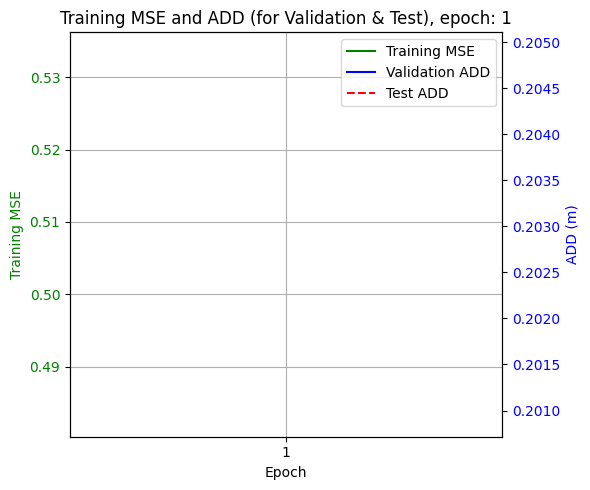


--------- Starting Epoch 2/35 ---------
>>>>>>>Current best ADD is 0.2009<<<<<<<<<
Invalid samples found in dataset: 2


Epoch 2 | Loss: 0.546265 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:49,  1.23s/it]


X loss:           0.000000
Y loss:           0.002089
Z loss:           0.015339
Rotation loss:    0.357170
Total loss:       0.374597
Angular error (deg): 72.84


Validation Loss: 0.539325, Avg ADD: 0.6265

Per-object ADD (mean):
  Object 01: ADD = 0.6462
  Object 02: ADD = 0.6689
  Object 04: ADD = 0.6268
  Object 05: ADD = 0.6439
  Object 06: ADD = 0.5147
  Object 08: ADD = 0.6501
  Object 09: ADD = 0.6349
  Object 10: ADD = 0.5673
  Object 11: ADD = 0.6648
  Object 12: ADD = 0.6451
  Object 13: ADD = 0.6289
  Object 14: ADD = 0.6672
  Object 15: ADD = 0.6348


Test Loss: 0.545797, Test ADD: 0.6274
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


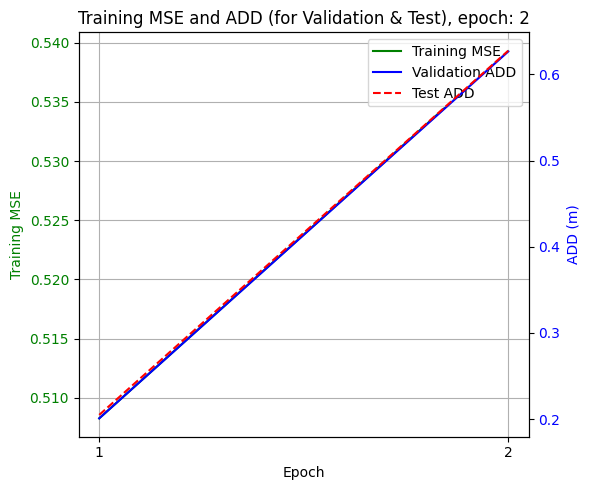


--------- Starting Epoch 3/35 ---------
>>>>>>>Current best ADD is 0.2009<<<<<<<<<
Invalid samples found in dataset: 3


Epoch 3 | Loss: 0.521365 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:19,  1.14s/it]


X loss:           0.000000
Y loss:           0.000042
Z loss:           0.001058
Rotation loss:    0.206850
Total loss:       0.207951
Angular error (deg): 52.46


Validation Loss: 0.501588, Avg ADD: 0.1273

Per-object ADD (mean):
  Object 01: ADD = 0.1188
  Object 02: ADD = 0.0980
  Object 04: ADD = 0.1535
  Object 05: ADD = 0.1136
  Object 06: ADD = 0.1953
  Object 08: ADD = 0.0953
  Object 09: ADD = 0.1119
  Object 10: ADD = 0.1653
  Object 11: ADD = 0.1085
  Object 12: ADD = 0.1156
  Object 13: ADD = 0.1443
  Object 14: ADD = 0.1040
  Object 15: ADD = 0.1229


Test Loss: 0.504965, Test ADD: 0.1276
✅ New best ADD: 0.1273 (saved locally)
☁️ New best ADD: 0.1273 (saved to Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


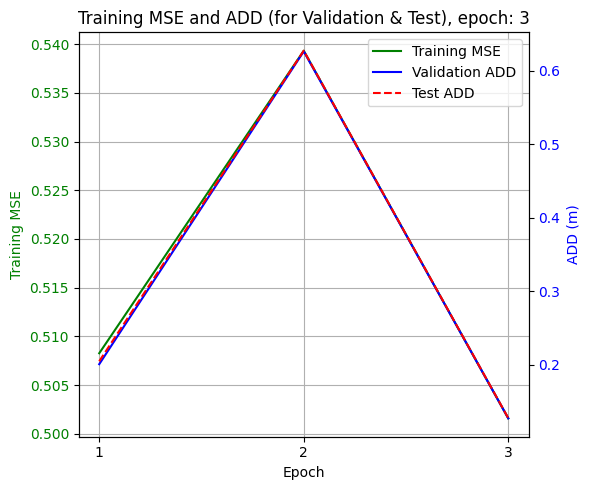


--------- Starting Epoch 4/35 ---------
>>>>>>>Current best ADD is 0.1273<<<<<<<<<
Invalid samples found in dataset: 4


Epoch 4 | Loss: 0.477751 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:20,  1.14s/it]


X loss:           0.000000
Y loss:           0.000300
Z loss:           0.000507
Rotation loss:    0.266933
Total loss:       0.267740
Angular error (deg): 61.00


Validation Loss: 0.500499, Avg ADD: 0.0955

Per-object ADD (mean):
  Object 01: ADD = 0.0615
  Object 02: ADD = 0.1162
  Object 04: ADD = 0.0812
  Object 05: ADD = 0.0996
  Object 06: ADD = 0.1255
  Object 08: ADD = 0.1298
  Object 09: ADD = 0.0668
  Object 10: ADD = 0.1013
  Object 11: ADD = 0.0886
  Object 12: ADD = 0.0790
  Object 13: ADD = 0.1056
  Object 14: ADD = 0.1081
  Object 15: ADD = 0.0904


Test Loss: 0.501677, Test ADD: 0.0954
✅ New best ADD: 0.0955 (saved locally)
☁️ New best ADD: 0.0955 (saved to Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


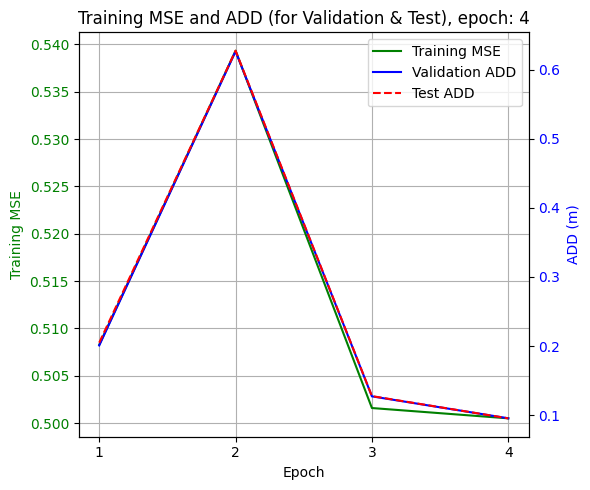


--------- Starting Epoch 5/35 ---------
>>>>>>>Current best ADD is 0.0955<<<<<<<<<
Invalid samples found in dataset: 5


Epoch 5 | Loss: 0.483733 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:41,  1.20s/it]


X loss:           0.000000
Y loss:           0.000138
Z loss:           0.000140
Rotation loss:    0.324546
Total loss:       0.324824
Angular error (deg): 68.78


Validation Loss: 0.504607, Avg ADD: 0.1575

Per-object ADD (mean):
  Object 01: ADD = 0.1027
  Object 02: ADD = 0.1804
  Object 04: ADD = 0.1211
  Object 05: ADD = 0.1679
  Object 06: ADD = 0.1857
  Object 08: ADD = 0.2056
  Object 09: ADD = 0.1186
  Object 10: ADD = 0.1854
  Object 11: ADD = 0.1608
  Object 12: ADD = 0.1459
  Object 13: ADD = 0.1509
  Object 14: ADD = 0.1675
  Object 15: ADD = 0.1430


Test Loss: 0.504747, Test ADD: 0.1576
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


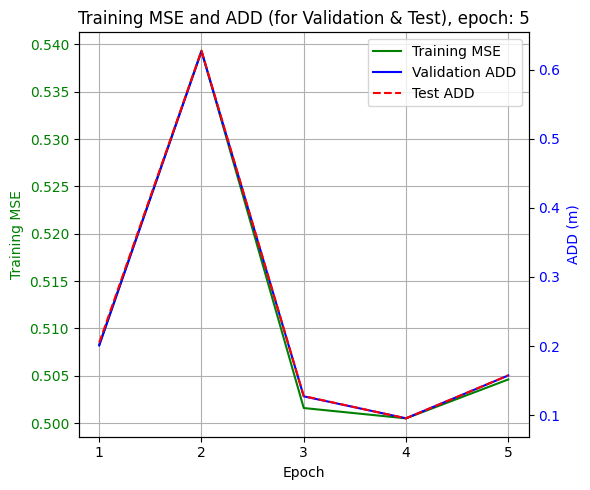


--------- Starting Epoch 6/35 ---------
>>>>>>>Current best ADD is 0.0955<<<<<<<<<
Invalid samples found in dataset: 6


Epoch 6 | Loss: 0.464338 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:09,  1.10s/it]


X loss:           0.000000
Y loss:           0.002089
Z loss:           0.015339
Rotation loss:    0.421351
Total loss:       0.438779
Angular error (deg): 80.77


Validation Loss: 0.522403, Avg ADD: 0.4115

Per-object ADD (mean):
  Object 01: ADD = 0.4175
  Object 02: ADD = 0.4565
  Object 04: ADD = 0.4124
  Object 05: ADD = 0.4558
  Object 06: ADD = 0.3875
  Object 08: ADD = 0.4633
  Object 09: ADD = 0.2184
  Object 10: ADD = 0.4193
  Object 11: ADD = 0.4346
  Object 12: ADD = 0.4340
  Object 13: ADD = 0.4317
  Object 14: ADD = 0.4491
  Object 15: ADD = 0.4315


Test Loss: 0.523488, Test ADD: 0.4134
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


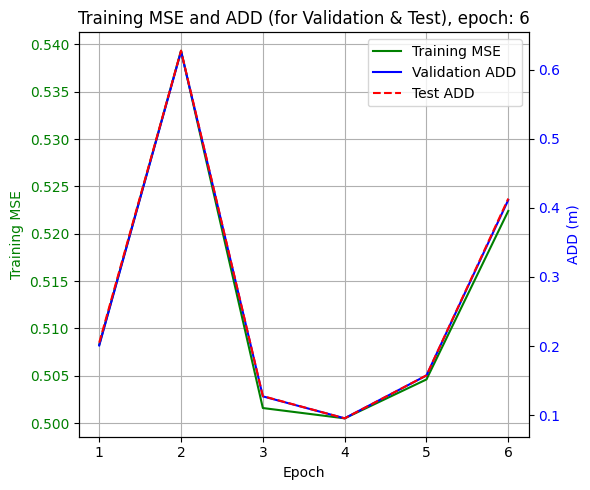


--------- Starting Epoch 7/35 ---------
>>>>>>>Current best ADD is 0.0955<<<<<<<<<
Invalid samples found in dataset: 7


Epoch 7 | Loss: 0.461511 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:11,  1.11s/it]


X loss:           0.000000
Y loss:           0.000011
Z loss:           0.003215
Rotation loss:    0.119591
Total loss:       0.122817
Angular error (deg): 37.90


Validation Loss: 0.504359, Avg ADD: 0.1601

Per-object ADD (mean):
  Object 01: ADD = 0.1422
  Object 02: ADD = 0.1491
  Object 04: ADD = 0.1932
  Object 05: ADD = 0.1496
  Object 06: ADD = 0.1806
  Object 08: ADD = 0.1287
  Object 09: ADD = 0.1507
  Object 10: ADD = 0.1846
  Object 11: ADD = 0.1619
  Object 12: ADD = 0.1630
  Object 13: ADD = 0.1955
  Object 14: ADD = 0.1403
  Object 15: ADD = 0.1645


Test Loss: 0.503362, Test ADD: 0.1589
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


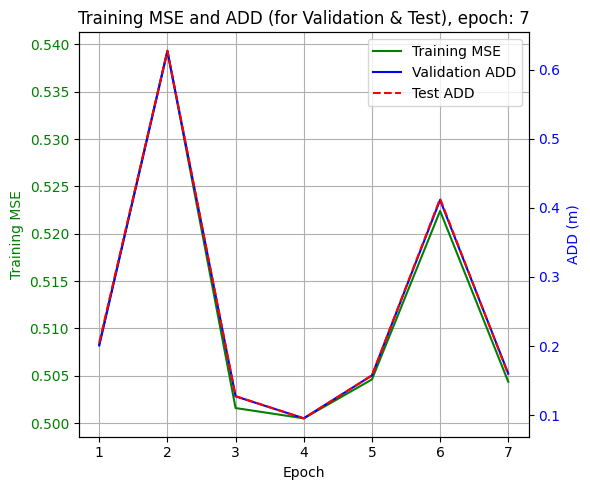


--------- Starting Epoch 8/35 ---------
>>>>>>>Current best ADD is 0.0955<<<<<<<<<
Invalid samples found in dataset: 8


Epoch 8 | Loss: 0.465420 | LR: 0.001000


Evaluating:   0%|          | 1/335 [00:01<06:46,  1.22s/it]


X loss:           0.000000
Y loss:           0.000377
Z loss:           0.000655
Rotation loss:    0.139336
Total loss:       0.140368
Angular error (deg): 41.49


Validation Loss: 0.499600, Avg ADD: 0.0960

Per-object ADD (mean):
  Object 01: ADD = 0.0752
  Object 02: ADD = 0.1104
  Object 04: ADD = 0.0840
  Object 05: ADD = 0.0894
  Object 06: ADD = 0.1094
  Object 08: ADD = 0.1343
  Object 09: ADD = 0.0717
  Object 10: ADD = 0.1015
  Object 11: ADD = 0.0991
  Object 12: ADD = 0.0801
  Object 13: ADD = 0.1073
  Object 14: ADD = 0.1100
  Object 15: ADD = 0.0843


Test Loss: 0.502330, Test ADD: 0.0957
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


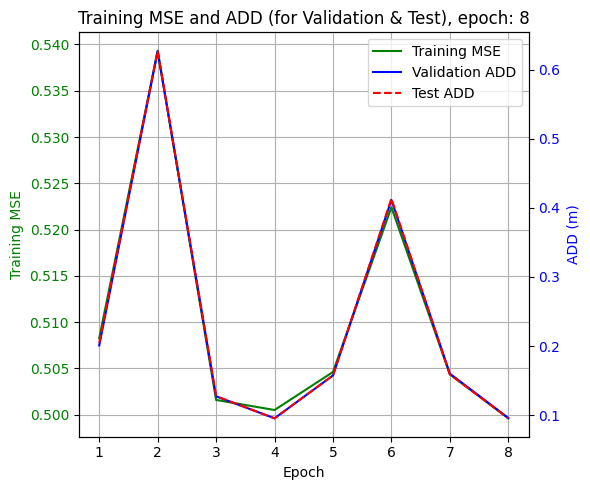


--------- Starting Epoch 9/35 ---------
>>>>>>>Current best ADD is 0.0955<<<<<<<<<
Invalid samples found in dataset: 9


Epoch 9 | Loss: 0.448288 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<06:16,  1.13s/it]


X loss:           0.000000
Y loss:           0.000196
Z loss:           0.000018
Rotation loss:    0.132871
Total loss:       0.133085
Angular error (deg): 40.35


Validation Loss: 0.497368, Avg ADD: 0.0796

Per-object ADD (mean):
  Object 01: ADD = 0.0512
  Object 02: ADD = 0.0870
  Object 04: ADD = 0.0844
  Object 05: ADD = 0.0761
  Object 06: ADD = 0.0992
  Object 08: ADD = 0.0967
  Object 09: ADD = 0.0644
  Object 10: ADD = 0.0916
  Object 11: ADD = 0.0632
  Object 12: ADD = 0.0723
  Object 13: ADD = 0.1031
  Object 14: ADD = 0.0906
  Object 15: ADD = 0.0757


Test Loss: 0.501063, Test ADD: 0.0795
✅ New best ADD: 0.0796 (saved locally)
☁️ New best ADD: 0.0796 (saved to Google Drive)
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


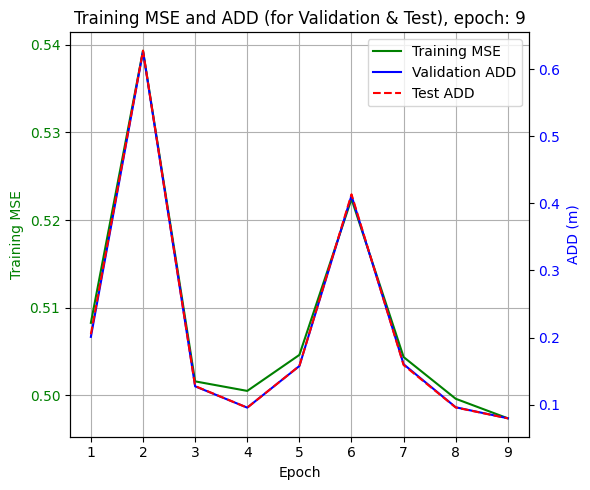


--------- Starting Epoch 10/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 10


Epoch 10 | Loss: 0.446178 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<06:17,  1.13s/it]


X loss:           0.000000
Y loss:           0.000310
Z loss:           0.000323
Rotation loss:    0.148841
Total loss:       0.149474
Angular error (deg): 43.18


Validation Loss: 0.496049, Avg ADD: 0.0871

Per-object ADD (mean):
  Object 01: ADD = 0.0612
  Object 02: ADD = 0.1131
  Object 04: ADD = 0.0832
  Object 05: ADD = 0.0850
  Object 06: ADD = 0.1009
  Object 08: ADD = 0.1129
  Object 09: ADD = 0.0651
  Object 10: ADD = 0.0942
  Object 11: ADD = 0.0712
  Object 12: ADD = 0.0771
  Object 13: ADD = 0.1126
  Object 14: ADD = 0.1001
  Object 15: ADD = 0.0817


Test Loss: 0.502185, Test ADD: 0.0867
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


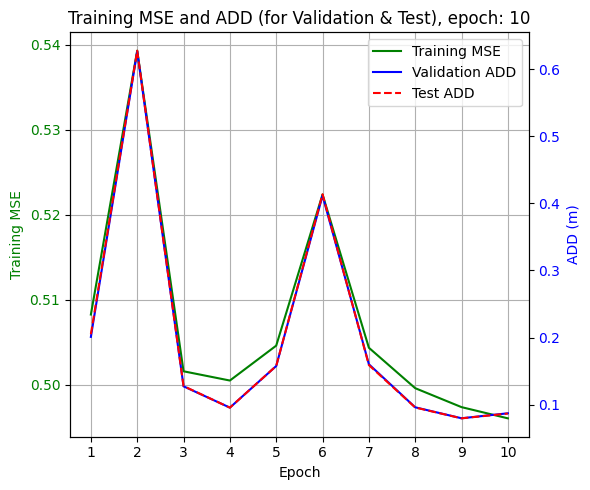


--------- Starting Epoch 11/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 11


Epoch 11 | Loss: 0.441380 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<06:07,  1.10s/it]


X loss:           0.000000
Y loss:           0.000114
Z loss:           0.000238
Rotation loss:    0.132632
Total loss:       0.132984
Angular error (deg): 40.28


Validation Loss: 0.497324, Avg ADD: 0.0877

Per-object ADD (mean):
  Object 01: ADD = 0.0656
  Object 02: ADD = 0.0910
  Object 04: ADD = 0.1043
  Object 05: ADD = 0.0793
  Object 06: ADD = 0.1072
  Object 08: ADD = 0.0829
  Object 09: ADD = 0.0810
  Object 10: ADD = 0.1096
  Object 11: ADD = 0.0763
  Object 12: ADD = 0.0773
  Object 13: ADD = 0.1065
  Object 14: ADD = 0.0917
  Object 15: ADD = 0.0894


Test Loss: 0.499539, Test ADD: 0.0870
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


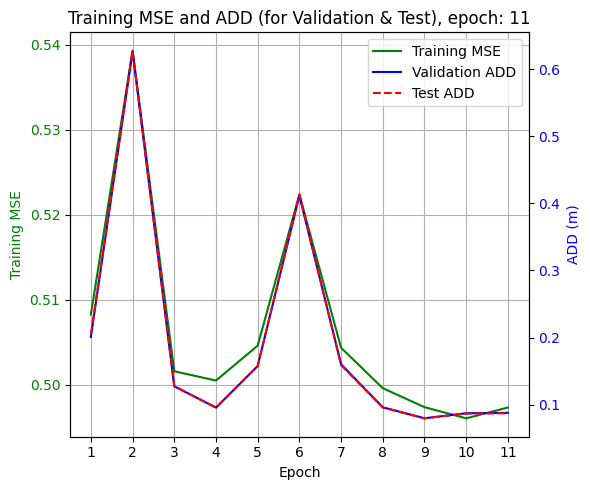


--------- Starting Epoch 12/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 12


Epoch 12 | Loss: 0.434987 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<06:29,  1.17s/it]


X loss:           0.000000
Y loss:           0.000034
Z loss:           0.001588
Rotation loss:    0.100892
Total loss:       0.102514
Angular error (deg): 34.18


Validation Loss: 0.496626, Avg ADD: 0.1265

Per-object ADD (mean):
  Object 01: ADD = 0.1029
  Object 02: ADD = 0.1224
  Object 04: ADD = 0.1390
  Object 05: ADD = 0.1157
  Object 06: ADD = 0.1718
  Object 08: ADD = 0.1064
  Object 09: ADD = 0.1130
  Object 10: ADD = 0.1481
  Object 11: ADD = 0.1148
  Object 12: ADD = 0.1257
  Object 13: ADD = 0.1513
  Object 14: ADD = 0.1172
  Object 15: ADD = 0.1298


Test Loss: 0.498989, Test ADD: 0.1257
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


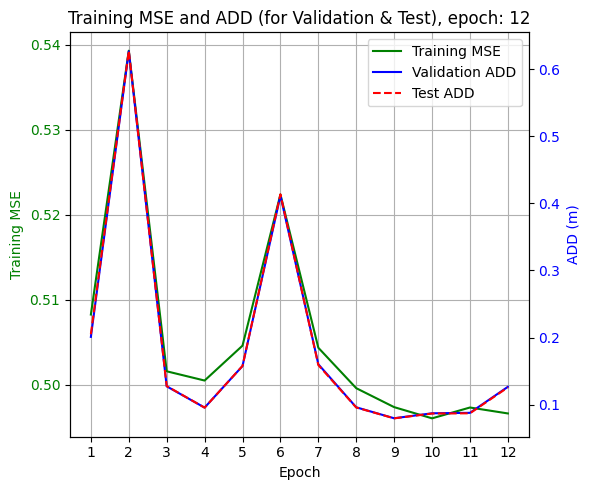


--------- Starting Epoch 13/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 13


Epoch 13 | Loss: 0.441936 | LR: 0.000100


Evaluating:   0%|          | 1/335 [00:01<06:18,  1.13s/it]


X loss:           0.000000
Y loss:           0.000647
Z loss:           0.002581
Rotation loss:    0.139815
Total loss:       0.143043
Angular error (deg): 41.61


Validation Loss: 0.496373, Avg ADD: 0.1498

Per-object ADD (mean):
  Object 01: ADD = 0.1225
  Object 02: ADD = 0.1723
  Object 04: ADD = 0.1337
  Object 05: ADD = 0.1589
  Object 06: ADD = 0.1441
  Object 08: ADD = 0.1987
  Object 09: ADD = 0.1173
  Object 10: ADD = 0.1572
  Object 11: ADD = 0.1510
  Object 12: ADD = 0.1342
  Object 13: ADD = 0.1595
  Object 14: ADD = 0.1632
  Object 15: ADD = 0.1489


Test Loss: 0.501796, Test ADD: 0.1491
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


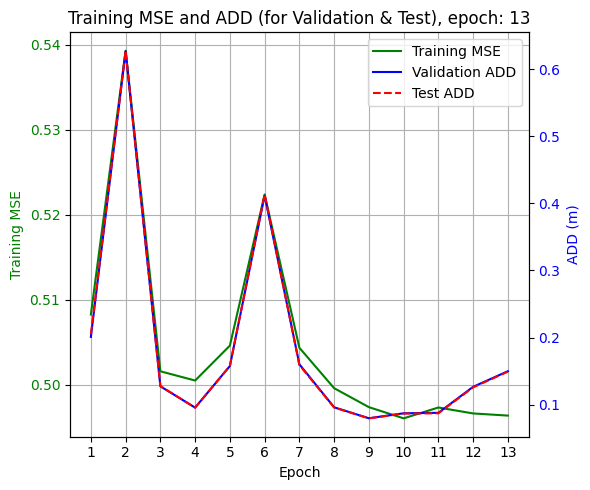


--------- Starting Epoch 14/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 14


Epoch 14 | Loss: 0.430904 | LR: 0.000010


Evaluating:   0%|          | 1/335 [00:01<06:19,  1.14s/it]


X loss:           0.000000
Y loss:           0.000444
Z loss:           0.001095
Rotation loss:    0.127382
Total loss:       0.128921
Angular error (deg): 39.35


Validation Loss: 0.486880, Avg ADD: 0.1122

Per-object ADD (mean):
  Object 01: ADD = 0.0822
  Object 02: ADD = 0.1363
  Object 04: ADD = 0.1064
  Object 05: ADD = 0.1189
  Object 06: ADD = 0.1071
  Object 08: ADD = 0.1552
  Object 09: ADD = 0.0841
  Object 10: ADD = 0.1204
  Object 11: ADD = 0.1082
  Object 12: ADD = 0.0946
  Object 13: ADD = 0.1234
  Object 14: ADD = 0.1342
  Object 15: ADD = 0.1140


Test Loss: 0.493117, Test ADD: 0.1123
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


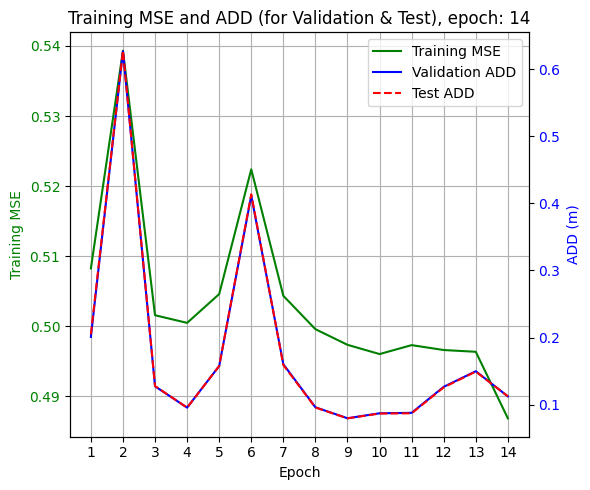


--------- Starting Epoch 15/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 15


Epoch 15 | Loss: 0.430278 | LR: 0.000010


Evaluating:   0%|          | 1/335 [00:01<06:06,  1.10s/it]


X loss:           0.000000
Y loss:           0.000396
Z loss:           0.000798
Rotation loss:    0.121788
Total loss:       0.122982
Angular error (deg): 38.32


Validation Loss: 0.484160, Avg ADD: 0.1090

Per-object ADD (mean):
  Object 01: ADD = 0.0774
  Object 02: ADD = 0.1340
  Object 04: ADD = 0.1031
  Object 05: ADD = 0.1185
  Object 06: ADD = 0.0989
  Object 08: ADD = 0.1517
  Object 09: ADD = 0.0826
  Object 10: ADD = 0.1180
  Object 11: ADD = 0.1035
  Object 12: ADD = 0.0908
  Object 13: ADD = 0.1238
  Object 14: ADD = 0.1330
  Object 15: ADD = 0.1113


Test Loss: 0.489369, Test ADD: 0.1089
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


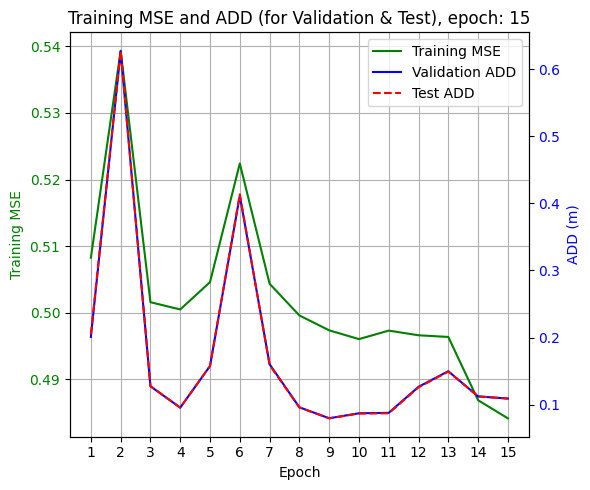


--------- Starting Epoch 16/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 16


Epoch 16 | Loss: 0.427831 | LR: 0.000010


Evaluating:   0%|          | 1/335 [00:01<09:04,  1.63s/it]


X loss:           0.000000
Y loss:           0.000238
Z loss:           0.000084
Rotation loss:    0.117749
Total loss:       0.118071
Angular error (deg): 37.55


Validation Loss: 0.477291, Avg ADD: 0.0826

Per-object ADD (mean):
  Object 01: ADD = 0.0569
  Object 02: ADD = 0.0949
  Object 04: ADD = 0.0789
  Object 05: ADD = 0.0851
  Object 06: ADD = 0.0847
  Object 08: ADD = 0.1031
  Object 09: ADD = 0.0707
  Object 10: ADD = 0.0920
  Object 11: ADD = 0.0669
  Object 12: ADD = 0.0793
  Object 13: ADD = 0.1038
  Object 14: ADD = 0.0998
  Object 15: ADD = 0.0775


Test Loss: 0.482076, Test ADD: 0.0829
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


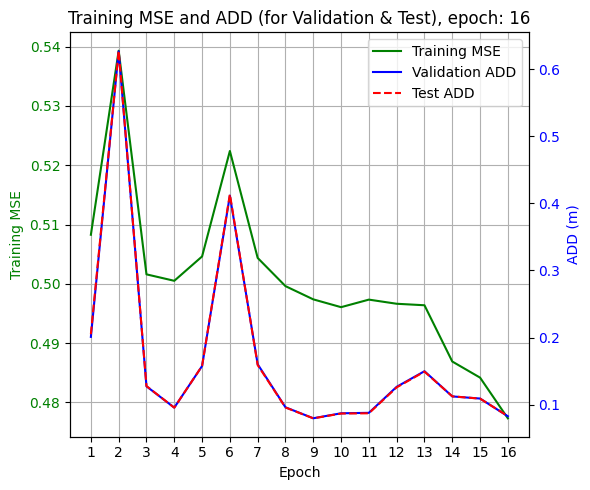


--------- Starting Epoch 17/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 17


Epoch 17 | Loss: 0.422950 | LR: 0.000010


Evaluating:   0%|          | 1/335 [00:01<06:10,  1.11s/it]


X loss:           0.000000
Y loss:           0.000344
Z loss:           0.000505
Rotation loss:    0.121647
Total loss:       0.122497
Angular error (deg): 38.29


Validation Loss: 0.477191, Avg ADD: 0.0932

Per-object ADD (mean):
  Object 01: ADD = 0.0773
  Object 02: ADD = 0.1058
  Object 04: ADD = 0.0884
  Object 05: ADD = 0.0987
  Object 06: ADD = 0.0920
  Object 08: ADD = 0.1211
  Object 09: ADD = 0.0739
  Object 10: ADD = 0.0986
  Object 11: ADD = 0.0832
  Object 12: ADD = 0.0787
  Object 13: ADD = 0.1112
  Object 14: ADD = 0.1145
  Object 15: ADD = 0.0895


Test Loss: 0.486933, Test ADD: 0.0938
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


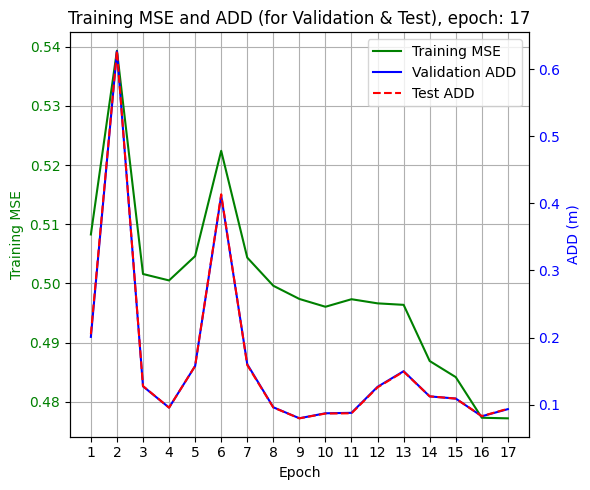


--------- Starting Epoch 18/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 18


Epoch 18 | Loss: 0.417708 | LR: 0.000001


Evaluating:   0%|          | 1/335 [00:01<06:17,  1.13s/it]


X loss:           0.000000
Y loss:           0.000422
Z loss:           0.000949
Rotation loss:    0.122138
Total loss:       0.123509
Angular error (deg): 38.39


Validation Loss: 0.474501, Avg ADD: 0.1090

Per-object ADD (mean):
  Object 01: ADD = 0.0984
  Object 02: ADD = 0.1206
  Object 04: ADD = 0.1021
  Object 05: ADD = 0.1172
  Object 06: ADD = 0.1026
  Object 08: ADD = 0.1441
  Object 09: ADD = 0.0955
  Object 10: ADD = 0.1106
  Object 11: ADD = 0.1027
  Object 12: ADD = 0.0864
  Object 13: ADD = 0.1149
  Object 14: ADD = 0.1304
  Object 15: ADD = 0.1047


Test Loss: 0.484331, Test ADD: 0.1094
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


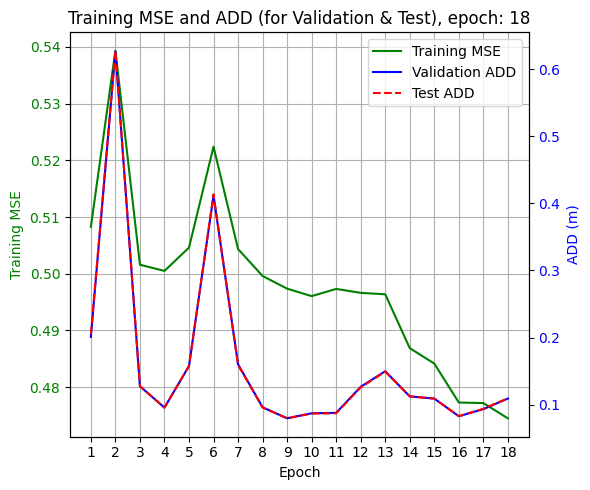


--------- Starting Epoch 19/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 19


Epoch 19 | Loss: 0.414716 | LR: 0.000001


Evaluating:   0%|          | 1/335 [00:01<06:09,  1.10s/it]


X loss:           0.000000
Y loss:           0.000438
Z loss:           0.001050
Rotation loss:    0.123929
Total loss:       0.125417
Angular error (deg): 38.73


Validation Loss: 0.474249, Avg ADD: 0.1147

Per-object ADD (mean):
  Object 01: ADD = 0.1042
  Object 02: ADD = 0.1322
  Object 04: ADD = 0.1075
  Object 05: ADD = 0.1243
  Object 06: ADD = 0.1024
  Object 08: ADD = 0.1537
  Object 09: ADD = 0.0973
  Object 10: ADD = 0.1150
  Object 11: ADD = 0.1091
  Object 12: ADD = 0.0927
  Object 13: ADD = 0.1232
  Object 14: ADD = 0.1370
  Object 15: ADD = 0.1098


Test Loss: 0.485202, Test ADD: 0.1154
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


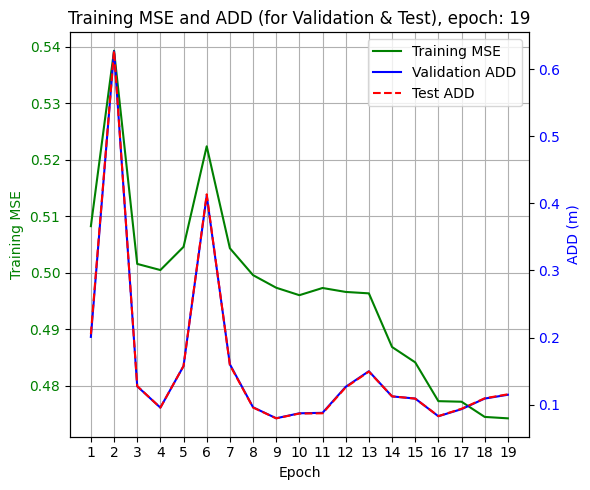


--------- Starting Epoch 20/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 20


Epoch 20 | Loss: 0.417565 | LR: 0.000001


Evaluating:   0%|          | 1/335 [00:01<06:13,  1.12s/it]


X loss:           0.000000
Y loss:           0.000349
Z loss:           0.000532
Rotation loss:    0.122379
Total loss:       0.123260
Angular error (deg): 38.44


Validation Loss: 0.471269, Avg ADD: 0.0970

Per-object ADD (mean):
  Object 01: ADD = 0.0843
  Object 02: ADD = 0.1145
  Object 04: ADD = 0.0904
  Object 05: ADD = 0.1024
  Object 06: ADD = 0.0923
  Object 08: ADD = 0.1327
  Object 09: ADD = 0.0788
  Object 10: ADD = 0.1002
  Object 11: ADD = 0.0901
  Object 12: ADD = 0.0753
  Object 13: ADD = 0.1109
  Object 14: ADD = 0.1179
  Object 15: ADD = 0.0898


Test Loss: 0.482061, Test ADD: 0.0974
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


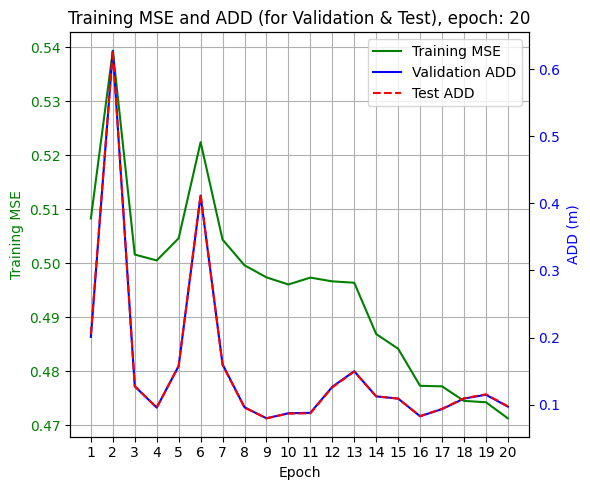


--------- Starting Epoch 21/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 21


Epoch 21 | Loss: 0.417000 | LR: 0.000001


Evaluating:   0%|          | 1/335 [00:01<06:26,  1.16s/it]


X loss:           0.000000
Y loss:           0.000355
Z loss:           0.000562
Rotation loss:    0.122933
Total loss:       0.123850
Angular error (deg): 38.54


Validation Loss: 0.470384, Avg ADD: 0.0945

Per-object ADD (mean):
  Object 01: ADD = 0.0812
  Object 02: ADD = 0.1106
  Object 04: ADD = 0.0888
  Object 05: ADD = 0.0989
  Object 06: ADD = 0.0926
  Object 08: ADD = 0.1305
  Object 09: ADD = 0.0744
  Object 10: ADD = 0.0994
  Object 11: ADD = 0.0870
  Object 12: ADD = 0.0729
  Object 13: ADD = 0.1084
  Object 14: ADD = 0.1141
  Object 15: ADD = 0.0888


Test Loss: 0.481824, Test ADD: 0.0949
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


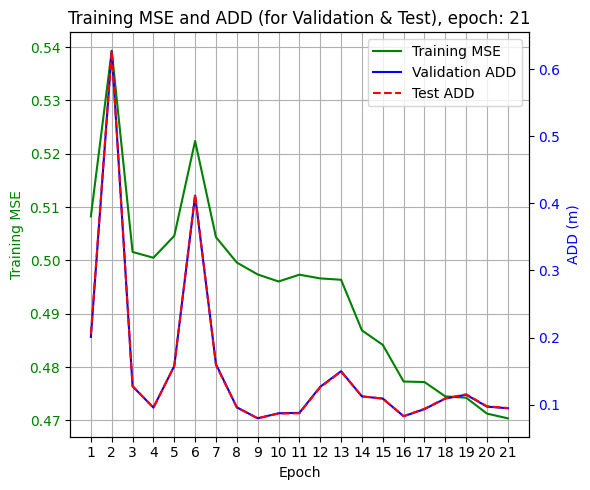


--------- Starting Epoch 22/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 22


Epoch 22 | Loss: 0.414571 | LR: 0.000000


Evaluating:   0%|          | 1/335 [00:01<06:09,  1.11s/it]


X loss:           0.000000
Y loss:           0.000353
Z loss:           0.000545
Rotation loss:    0.121996
Total loss:       0.122894
Angular error (deg): 38.37


Validation Loss: 0.469380, Avg ADD: 0.0969

Per-object ADD (mean):
  Object 01: ADD = 0.0840
  Object 02: ADD = 0.1128
  Object 04: ADD = 0.0921
  Object 05: ADD = 0.1029
  Object 06: ADD = 0.0923
  Object 08: ADD = 0.1341
  Object 09: ADD = 0.0764
  Object 10: ADD = 0.1003
  Object 11: ADD = 0.0898
  Object 12: ADD = 0.0756
  Object 13: ADD = 0.1098
  Object 14: ADD = 0.1176
  Object 15: ADD = 0.0909


Test Loss: 0.479864, Test ADD: 0.0973
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


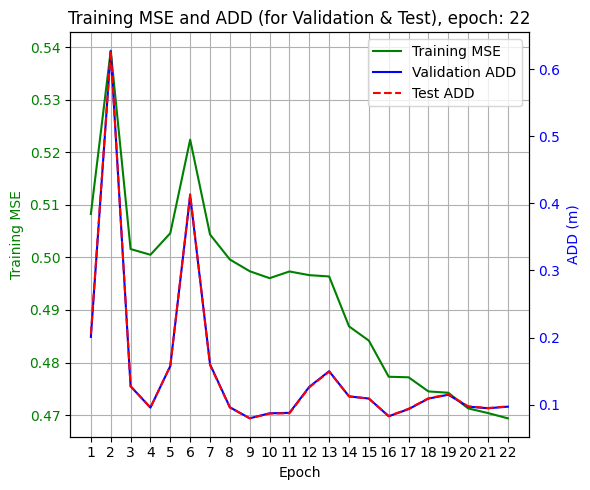


--------- Starting Epoch 23/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 23


Epoch 23 | Loss: 0.416323 | LR: 0.000000


Evaluating:   0%|          | 1/335 [00:01<06:11,  1.11s/it]


X loss:           0.000000
Y loss:           0.000362
Z loss:           0.000587
Rotation loss:    0.119794
Total loss:       0.120743
Angular error (deg): 37.96


Validation Loss: 0.467157, Avg ADD: 0.0958

Per-object ADD (mean):
  Object 01: ADD = 0.0835
  Object 02: ADD = 0.1112
  Object 04: ADD = 0.0934
  Object 05: ADD = 0.1028
  Object 06: ADD = 0.0933
  Object 08: ADD = 0.1307
  Object 09: ADD = 0.0700
  Object 10: ADD = 0.1023
  Object 11: ADD = 0.0857
  Object 12: ADD = 0.0775
  Object 13: ADD = 0.1079
  Object 14: ADD = 0.1141
  Object 15: ADD = 0.0923


Test Loss: 0.476585, Test ADD: 0.0961
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


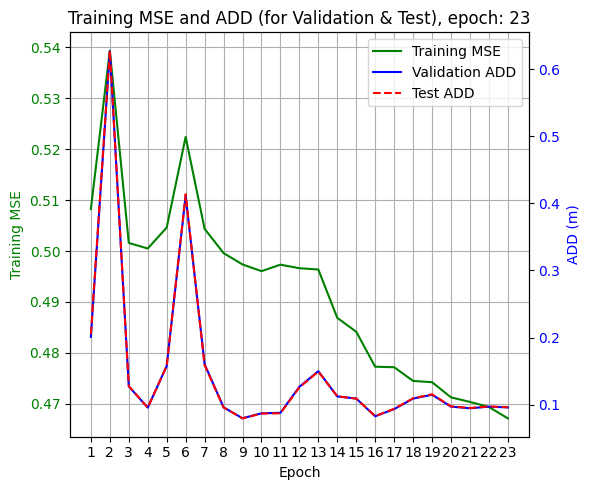


--------- Starting Epoch 24/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 24


Epoch 24 | Loss: 0.413717 | LR: 0.000000


Evaluating:   0%|          | 1/335 [00:01<06:09,  1.11s/it]


X loss:           0.000000
Y loss:           0.000328
Z loss:           0.000413
Rotation loss:    0.118007
Total loss:       0.118748
Angular error (deg): 37.61


Validation Loss: 0.467447, Avg ADD: 0.0887

Per-object ADD (mean):
  Object 01: ADD = 0.0730
  Object 02: ADD = 0.1036
  Object 04: ADD = 0.0884
  Object 05: ADD = 0.0936
  Object 06: ADD = 0.0893
  Object 08: ADD = 0.1189
  Object 09: ADD = 0.0637
  Object 10: ADD = 0.0980
  Object 11: ADD = 0.0753
  Object 12: ADD = 0.0734
  Object 13: ADD = 0.1057
  Object 14: ADD = 0.1051
  Object 15: ADD = 0.0865


Test Loss: 0.476429, Test ADD: 0.0889
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


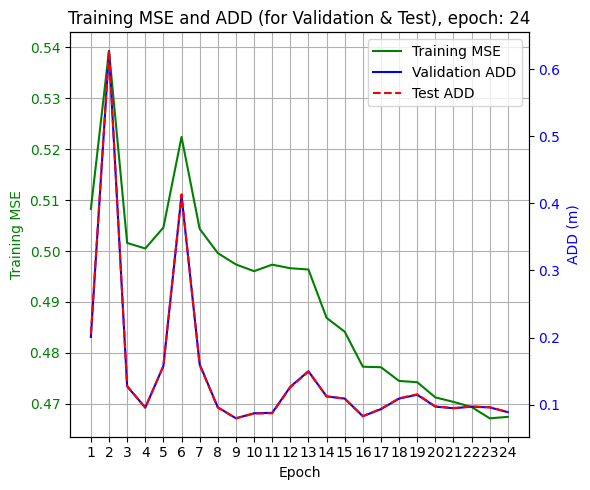


--------- Starting Epoch 25/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 25


Epoch 25 | Loss: 0.409710 | LR: 0.000000


Evaluating:   0%|          | 1/335 [00:01<06:05,  1.09s/it]


X loss:           0.000000
Y loss:           0.000378
Z loss:           0.000683
Rotation loss:    0.121994
Total loss:       0.123055
Angular error (deg): 38.37


Validation Loss: 0.468219, Avg ADD: 0.1021

Per-object ADD (mean):
  Object 01: ADD = 0.0903
  Object 02: ADD = 0.1221
  Object 04: ADD = 0.0970
  Object 05: ADD = 0.1091
  Object 06: ADD = 0.0949
  Object 08: ADD = 0.1410
  Object 09: ADD = 0.0794
  Object 10: ADD = 0.1045
  Object 11: ADD = 0.0950
  Object 12: ADD = 0.0821
  Object 13: ADD = 0.1135
  Object 14: ADD = 0.1221
  Object 15: ADD = 0.0962


Test Loss: 0.479157, Test ADD: 0.1026
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


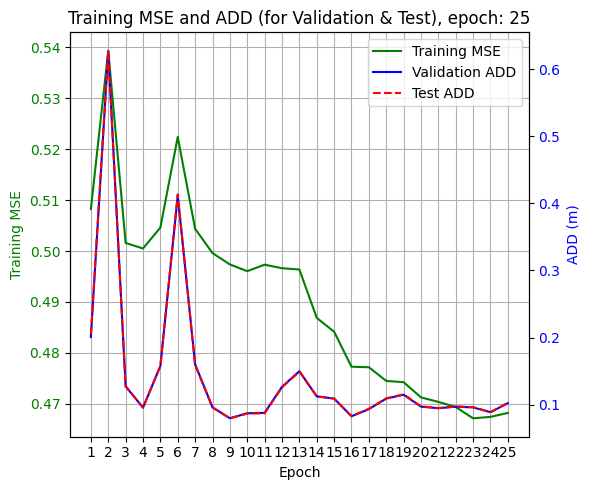


--------- Starting Epoch 26/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 26


Epoch 26 | Loss: 0.410906 | LR: 0.000000


Evaluating:   0%|          | 1/335 [00:01<06:19,  1.14s/it]


X loss:           0.000000
Y loss:           0.000369
Z loss:           0.000631
Rotation loss:    0.123041
Total loss:       0.124041
Angular error (deg): 38.57


Validation Loss: 0.469067, Avg ADD: 0.0995

Per-object ADD (mean):
  Object 01: ADD = 0.0880
  Object 02: ADD = 0.1185
  Object 04: ADD = 0.0945
  Object 05: ADD = 0.1051
  Object 06: ADD = 0.0934
  Object 08: ADD = 0.1383
  Object 09: ADD = 0.0776
  Object 10: ADD = 0.1023
  Object 11: ADD = 0.0918
  Object 12: ADD = 0.0792
  Object 13: ADD = 0.1119
  Object 14: ADD = 0.1193
  Object 15: ADD = 0.0930


Test Loss: 0.480831, Test ADD: 0.1000
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


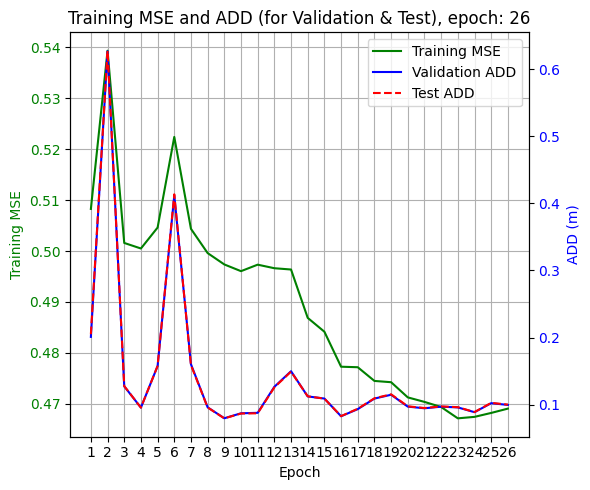


--------- Starting Epoch 27/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 27


Epoch 27 | Loss: 0.417767 | LR: 0.000000


Evaluating:   0%|          | 1/335 [00:01<07:48,  1.40s/it]


X loss:           0.000000
Y loss:           0.000336
Z loss:           0.000459
Rotation loss:    0.121215
Total loss:       0.122010
Angular error (deg): 38.22


Validation Loss: 0.468156, Avg ADD: 0.0936

Per-object ADD (mean):
  Object 01: ADD = 0.0773
  Object 02: ADD = 0.1171
  Object 04: ADD = 0.0891
  Object 05: ADD = 0.0976
  Object 06: ADD = 0.0901
  Object 08: ADD = 0.1285
  Object 09: ADD = 0.0711
  Object 10: ADD = 0.0978
  Object 11: ADD = 0.0825
  Object 12: ADD = 0.0791
  Object 13: ADD = 0.1110
  Object 14: ADD = 0.1109
  Object 15: ADD = 0.0872


Test Loss: 0.479405, Test ADD: 0.0941
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


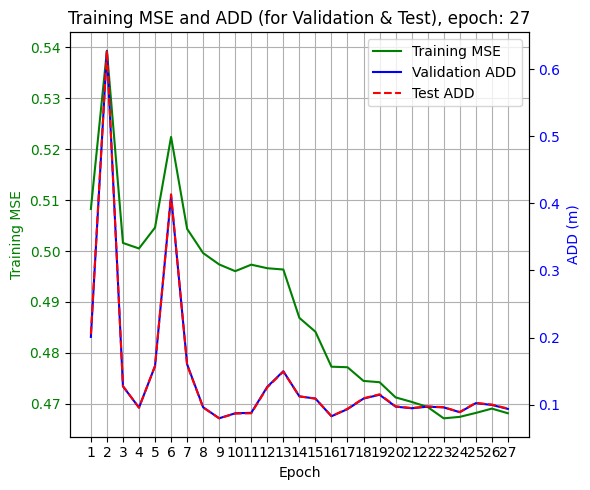


--------- Starting Epoch 28/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 28


Epoch 28 | Loss: 0.411379 | LR: 0.000000


Evaluating:   0%|          | 1/335 [00:01<06:07,  1.10s/it]


X loss:           0.000000
Y loss:           0.000374
Z loss:           0.000658
Rotation loss:    0.120944
Total loss:       0.121976
Angular error (deg): 38.17


Validation Loss: 0.467868, Avg ADD: 0.0988

Per-object ADD (mean):
  Object 01: ADD = 0.0860
  Object 02: ADD = 0.1144
  Object 04: ADD = 0.0945
  Object 05: ADD = 0.1060
  Object 06: ADD = 0.0954
  Object 08: ADD = 0.1357
  Object 09: ADD = 0.0761
  Object 10: ADD = 0.1039
  Object 11: ADD = 0.0904
  Object 12: ADD = 0.0773
  Object 13: ADD = 0.1097
  Object 14: ADD = 0.1185
  Object 15: ADD = 0.0942


Test Loss: 0.478273, Test ADD: 0.0992
💾 Checkpoint saved locally.
☁️ Checkpoint saved to Google Drive.


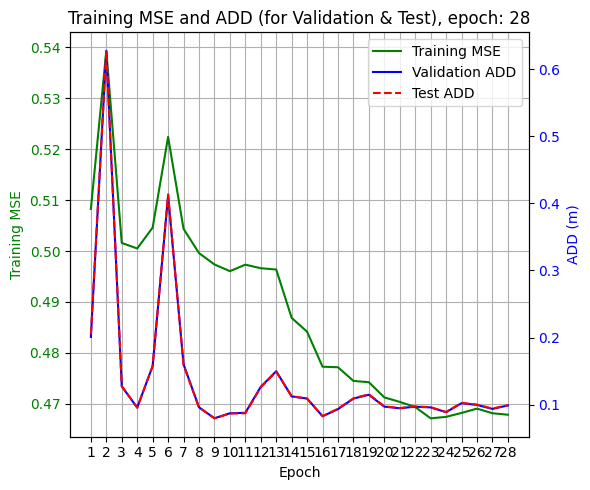


--------- Starting Epoch 29/35 ---------
>>>>>>>Current best ADD is 0.0796<<<<<<<<<
Invalid samples found in dataset: 29


Epoch 29 | Loss: 0.412930 | LR: 0.000000


Evaluating:   0%|          | 1/335 [00:01<06:25,  1.15s/it]


X loss:           0.000000
Y loss:           0.000363
Z loss:           0.000598
Rotation loss:    0.120669
Total loss:       0.121630
Angular error (deg): 38.11


Validation Loss: 0.470635, Avg ADD: 0.1020

Per-object ADD (mean):
  Object 01: ADD = 0.0837
  Object 02: ADD = 0.1335
  Object 04: ADD = 0.0948
  Object 05: ADD = 0.1038
  Object 06: ADD = 0.0934
  Object 08: ADD = 0.1372
  Object 09: ADD = 0.0740
  Object 10: ADD = 0.1021
  Object 11: ADD = 0.0879
  Object 12: ADD = 0.1076
  Object 13: ADD = 0.1217
  Object 14: ADD = 0.1156
  Object 15: ADD = 0.0934


Test Loss: 0.480855, Test ADD: 0.1026
🛑 Early stopping triggered.
🏁 Training complete.
Best Validation ADD: 0.0796
Best Test ADD: 0.0795
Final Validation Loss: 0.470635


In [ ]:
# Flags to control where checkpoints are saved.
SAVE_LOCAL = True
SAVE_DRIVE = True

# Determining the number of objects in dataset.
_, num_objects = train_dataset.getMappedIDs()
num_obj = len(num_objects)
print(f"This RGB-D model will be trained to find {num_obj} object(s).")

# === Initialize the RGB-D model ===
model = PoseNet6D_RGBD(
    num_objects=num_obj,
    embedding_dim=16,
    img_size=(224, 224)
)

# === Launch training ===
model, _, _ = train_and_evaluate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    full_project_path=full_project_path,
    num_epochs=35,
    patience=20,
    use_mask_on_depth=True,
    use_mask_on_rgb=True,
    track_per_object=True
  )

## Functions for plotting the results

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image

def draw_model_projection(image, points, color, radius=1):
    """
    Draws projected 2D model points as circles on the image.

    Args:
        image (np.ndarray): BGR image.
        points (np.ndarray): 2D projected points (N, 2).
        color (tuple): BGR color (e.g., (0, 255, 0)).
        radius (int): Radius of the circle to draw.
    """
    for pt in points.astype(int):
        x, y = pt
        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            cv2.circle(image, (x, y), radius, color, -1)

def draw_legend(image, labels_colors):
    """
    Draws a simple color legend (e.g., "GT" vs "Pred") on the image.

    Args:
        image (np.ndarray): BGR image.
        labels_colors (list): List of (label, color) pairs.
    """
    x, y, spacing = 10, 25, 25
    font_scale = 0.4
    text_thickness = 1
    box_width = 10
    box_height = 10
    for i, (label, color) in enumerate(labels_colors):
        cv2.putText(image, label, (x + box_width + 5, y + i * spacing),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, text_thickness)
        cv2.rectangle(image,
                      (x, y - box_height // 2 + i * spacing),
                      (x + box_width, y + box_height // 2 + i * spacing),
                      color, -1)

def draw_axes(image, R, t, K, is_gt=False, axis_length=0.05, thickness=2):
    """
    Projects and draws coordinate axes (X, Y, Z) for a given pose.

    Args:
        image (np.ndarray): BGR image.
        R (np.ndarray): 3x3 rotation matrix.
        t (np.ndarray): 3D translation vector.
        K (np.ndarray): 3x3 camera intrinsic matrix.
        is_gt (bool): Whether this is ground truth (duller colors).
        axis_length (float): Length of axes in meters.
        thickness (int): Line thickness.

    Returns:
        np.ndarray: Annotated image.
    """
    axes_3d = np.array([[0, 0, 0],
                        [axis_length, 0, 0],
                        [0, axis_length, 0],
                        [0, 0, axis_length]], dtype=np.float32)

    pts_2d = (K @ (axes_3d @ R.T + t).T).T
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:3]
    pts_2d = pts_2d.astype(int)

    origin = tuple(pts_2d[0])
    cv2.circle(image, origin, 6, (255, 255, 255), -1)

    color_map = [(0, 0, 255), (0, 255, 0), (255, 0, 0)] if not is_gt else \
                [(100, 100, 255), (100, 255, 100), (255, 100, 100)]

    for i in range(1, 4):
        cv2.line(image, origin, tuple(pts_2d[i]), color_map[i - 1], thickness)

    return image

def project(pts, R, t, K):
    """
    Projects 3D model points into 2D image space.

    Args:
        pts (np.ndarray): 3D model points (N, 3).
        R (np.ndarray): 3x3 rotation matrix.
        t (np.ndarray): 3D translation vector.
        K (np.ndarray): 3x3 camera intrinsics.

    Returns:
        np.ndarray: 2D projected points (N, 2).
    """
    proj = (K @ (pts @ R.T + t).T).T
    return proj[:, :2] / proj[:, 2:3]

def visualize_pose_prediction(obj, model, dataset, obj_id, device,
                              draw_axes_flag=False, draw_models=True, use_full_frame=True,
                              save_dir=None, save_prefix="result", legend=False):
    """
    Visualizes predicted vs ground truth pose for a given object crop.

    Args:
        obj (dict): Single object crop entry from dataset.
        model (nn.Module): PoseNet model.
        dataset (PoseEstimationDataset): Dataset instance (for 3D model lookup).
        obj_id (int): Mapped object ID (internal index).
        device (torch.device): Device to run inference on.
        draw_axes_flag (bool): Whether to draw 3D coordinate axes.
        draw_models (bool): Whether to draw full model projections.
        use_full_frame (bool): Whether to also show full frame projection.
        save_dir (str): Directory to save visualizations (optional).
        save_prefix (str): Filename prefix for saved files.
        legend (bool): Whether to draw a color legend.
    """
    # Prepare the model inputs.
    rgb = obj['cropped_rgb'].unsqueeze(0).to(device)
    crop_depth = obj['cropped_depth'].unsqueeze(0).to(device)
    norm_bbox = obj['norm_bbox'].unsqueeze(0).to(device)
    cropped_K = obj['cropped_K'].unsqueeze(0).to(device)
    obj_tensor = torch.tensor([obj_id], dtype=torch.long).to(device)

    R_gt = obj['rotation']
    t_gt = obj['translation']

    # Inference.
    with torch.no_grad():
        t_pred, quat_pred = model(rgb, crop_depth, norm_bbox, cropped_K, obj_tensor)

    # Convert predictions to the correct format.
    R_pred = quaternion_to_matrix_batch(quat_pred.detach()).squeeze().cpu().numpy()
    t_pred = t_pred.detach().squeeze().cpu().numpy()

    quat_gt = matrix_to_quaternion_batch(torch.tensor(R_gt, dtype=torch.float32).to(device))
    with torch.no_grad():
        ang_err = quaternion_angular_error(quat_pred, quat_gt).item()

    # Load 3D model.
    original_id = dataset.idx_to_id[obj_id]
    model_points = dataset.load_3D_model(original_id)

    # === Visualize Cropped Image ===
    crop_rgb = obj['cropped_rgb'].cpu().numpy().transpose(1, 2, 0)
    crop_rgb = ((crop_rgb * 0.229 + 0.485).clip(0, 1) * 255).astype(np.uint8)
    crop_rgb = cv2.cvtColor(crop_rgb, cv2.COLOR_RGB2BGR)
    cropped_K_np = cropped_K.squeeze().cpu().numpy()
    vis_crop = crop_rgb.copy()

    if draw_axes_flag:
        vis_crop = draw_axes(vis_crop, R_pred, t_pred, cropped_K_np)
        vis_crop = draw_axes(vis_crop, R_gt, t_gt, cropped_K_np, is_gt=True)

    if draw_models:
        proj_gt = project(model_points, R_gt, t_gt, cropped_K_np)
        proj_pred = project(model_points, R_pred, t_pred, cropped_K_np)
        draw_model_projection(vis_crop, proj_gt, (0, 255, 0))
        draw_model_projection(vis_crop, proj_pred, (0, 0, 255))

    if legend:
        draw_legend(vis_crop, [("GT", (0, 255, 0)), ("Pred", (0, 0, 255))])

    # Computing the ADD metric.
    add = computeADD(R_pred, t_pred, R_gt, t_gt, model_points)
    print(f"\n➡️ Mapped object ID {obj_id:02d}")
    print(f"ADD: {add:.4f} m | Angular Error: {ang_err:.2f}°")

    plt.figure()
    plt.imshow(cv2.cvtColor(vis_crop, cv2.COLOR_BGR2RGB))
    plt.title(f"[Cropped] Obj {original_id:02d}")
    plt.axis("off")
    plt.show()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{save_prefix}_cropped_obj{obj_id:02d}.png")
        cv2.imwrite(save_path, vis_crop)

    # === Visualize Full Image View ===
    if use_full_frame:
        full_image = cv2.cvtColor(np.array(obj['original_rgb']), cv2.COLOR_RGB2BGR)
        original_K = obj['original_K'].numpy()

        if draw_axes_flag:
            full_image = draw_axes(full_image, R_pred, t_pred, original_K)
            full_image = draw_axes(full_image, R_gt, t_gt, original_K, is_gt=True)

        if draw_models:
            proj_gt_full = project(model_points, R_gt, t_gt, original_K)
            proj_pred_full = project(model_points, R_pred, t_pred, original_K)
            draw_model_projection(full_image, proj_gt_full, (0, 255, 0))
            draw_model_projection(full_image, proj_pred_full, (0, 0, 255))

        if legend:
            draw_legend(full_image, [("GT", (0, 255, 0)), ("Pred", (0, 0, 255))])

        plt.figure()
        plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
        plt.title(f"[Full Frame] Obj {original_id:02d}")
        plt.axis("off")
        plt.show()

        if save_dir:
            save_path = os.path.join(save_dir, f"{save_prefix}_fullframe_obj{obj_id:02d}.png")
            cv2.imwrite(save_path, full_image)

def run_visualization(model, dataset, device, target_obj_ids,
                      img_idx=0, save_dir=None, draw_axes=False,
                      draw_legend=False, draw_models=False):
    """
    Runs pose prediction visualization for selected objects in a given image.

    Args:
        model (nn.Module): Trained PoseNet model.
        dataset (Dataset): PoseEstimationDataset instance.
        device (torch.device): CUDA or CPU device.
        target_obj_ids (set): Set of internal object IDs to visualize.
        img_idx (int): Index of the sample image to visualize.
        save_dir (str): Directory to save images (optional).
        draw_axes (bool): Whether to draw 3D coordinate axes.
        draw_legend (bool): Whether to draw GT/Pred legend.
        draw_models (bool): Whether to project and overlay 3D models.
    """
    model.eval()
    idx_to_id = {v: k for k, v in dataset.id_to_idx.items()}

    with torch.no_grad():
        data_item = dataset[img_idx]
        found_obj_ids = set()

        original_rgb = data_item['original_rgb']
        original_K = data_item['original_K']

        for obj in data_item['objects']:
            obj_id = obj['object_id']
            if obj_id in target_obj_ids:
                found_obj_ids.add(obj_id)

                # Inject full image and intrinsics into the object for visualization.
                obj['original_rgb'] = original_rgb
                obj['original_K'] = original_K

                visualize_pose_prediction(
                    obj, model, dataset, obj_id, device,
                    draw_axes_flag=draw_axes,
                    draw_models=draw_models,
                    legend=draw_legend,
                    save_dir=save_dir,
                    save_prefix=f"img{img_idx:03d}_obj{obj_id:02d}"
                )

        # Warn if some requested objects weren't present in the image.
        missing_ids = set(target_obj_ids) - found_obj_ids
        if missing_ids:
            missing_original_ids = sorted([idx_to_id[mapped_id] for mapped_id in missing_ids])
            print(f"⚠️ Note: These object IDs (mapped) were not present in image {img_idx}: {sorted(missing_ids)}")

## Plotting the results

In [ ]:
# --- Dataset & Paths ---
dataset_root = os.path.join(full_project_path, 'path/to/data')
models_root = os.path.join(full_project_path, "path/to/models")

# Load a subset (e.g., objects 1 and 13)
folders = [2] # List of folder [1,2,3].
dataset = PoseEstimationDataset_RGBD(dataset_root,
                                models_root,
                                folders=folders)

In [ ]:
# Print the available object IDs from dataset.
print("Object IDs in dataset:", dataset.object_ids)  # Original LineMOD object IDs.
all_mapped_ids, _ = dataset.getMappedIDs()
print("Mapped IDs:", all_mapped_ids)  # Internally mapped IDs used in training/evaluation

# === Select which original object IDs to visualize ===
original_ids_to_visualize = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
# original_ids_to_visualize = [13]  # If you want to test a single object.

# === Load Trained Model ===
num_objects = len(original_ids_to_visualize)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model with same number of object classes used during training.
model = PoseNet_RGBD(num_objects=13)

# Load pretrained model weights
model.load_state_dict(torch.load('/content/best_posenet_OP.pt', map_location=device))
model.to(device)

# === Prepare Visualization Parameters ===
# Convert original LineMOD IDs to internal mapped IDs.
mapped_ids, _ = dataset.getMappedIDs(original_ids_to_visualize)

img_idx = 20 # Datasets index of the image to visualize.
save_dir = "/content/visualizations"  # Folder to save visualization images.

# === Run Visualization ===
run_visualization(
    model=model,
    dataset=dataset,
    device=device,
    target_obj_ids=mapped_ids,  # Mapped object IDs to look for in the selected image.
    img_idx=img_idx,
    save_dir=save_dir,
    draw_axes=True,     # Draw 3D coordinate axes (Pred vs GT).
    draw_legend=False,  # Hide the GT/Pred legend.
    draw_models=False   # Visualize 3D model for GT (green) and pred (red).
)